# Projeto ML - Previsão de vendas em varejo:
 Esse projeto tem como objetivo a previsão de vendas de grupos de produtos na franquia de lojas de varejo Favorita no Equador, esse dataset pertence a uma competição do site Kaggle, no link https://www.kaggle.com/competitions/store-sales-time-series-forecasting.

## Parte 1 - Organização dos dados:

### Carregando bibliotecas:

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import scipy.stats as ss
import tensorflow as tf
import optuna
import xgboost as xgb

### Carregando classes e métodos:

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Carregando dados:

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
oil_df = pd.read_csv("oil.csv")
stores_df = pd.read_csv("stores.csv")
holidays_df = pd.read_csv("holidays_events.csv")
sample_df = pd.read_csv("sample_submission.csv")

In [6]:
display(train_df.head(1),
        test_df.head(1),
        oil_df.head(1),
        stores_df.head(1),
        holidays_df.head(1),
        sample_df.head(1))

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


,date,dcoilwtico
0,2013-01-01,NaN


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


,id,sales
0,3000888,0.0


#### Juntando as databases:

In [7]:
train_df = train_df.merge(oil_df, how = 'left', on = 'date')
train_df = train_df.merge(stores_df, how = 'left', on = 'store_nbr')
train_df = train_df.merge(holidays_df, how = 'left', on = 'date' )

In [8]:
train_df.rename(columns={'type_x':'type_store','type_y':'type_holiday'},inplace=True)
train_df.drop('description',axis=1,inplace=True)

### Entendimento do problema:

O propósito do projeto é montar um modelo de regressão, que preveja com precisão as vendas dos produtos por categoria. Uma informação muito valiosa para a empresa, pois só é possível elaborar um planejamento detalhado para o crescimento da empresa, através de um conhecimento profundo de como o mercado vai se comportar no futuro, sendo deste modo, muito mais fácil idealizar suas metas e objetivos, além de melhorar a alocação de recursos em áreas de investimento propício.

## Parte 2 - Análise Exploratória:

### Conhecendo os dados:

#### Proporções:

In [9]:
print(f'O dataframe tem {train_df.shape[0]} linhas e {train_df.shape[1]} colunas')

O dataframe tem 3054348 linhas e 15 colunas


O dataframe tem um número grande de linhas, o que pode ser um problema no momento da modelagem, a quantidade de colunas é mediana, se não forem bem trabalhadas podem levar um problema de dimensionalidade.

#### Estatísticas descritivas:

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   dcoilwtico    float64
 7   city          object 
 8   state         object 
 9   type_store    object 
 10  cluster       int64  
 11  type_holiday  object 
 12  locale        object 
 13  locale_name   object 
 14  transferred   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 372.8+ MB


Só existem duas colunas numéricas contínuas na base de dados, **"dcoilwtico"** e **"sales"**, as outras colunas são todas de função categórica.

In [11]:
train_df.describe()[['sales','dcoilwtico']]

,sales,dcoilwtico
count,3.054348e+06,2.099196e+06
mean,3.590209e+02,6.801587e+01
std,1.107286e+03,2.569134e+01
min,0.000000e+00,2.619000e+01
25%,0.000000e+00,4.641000e+01
50%,1.100000e+01,5.343000e+01
75%,1.960110e+02,9.581000e+01
max,1.247170e+05,1.106200e+02


Os preços do petróleo são bem semelhantes, não havendo grandes discrepâncias, como mostrado na distribuição de dados da coluna **"dcoilwtico"**. Já a coluna **"sales"** mostra uma grande variação, pois há uma grande diferença entre o 1° quartil e o último.

#### Valores nulos:

In [12]:
missing_values = train_df.isna().mean()
lista_missing_values = missing_values.index.to_list()

In [13]:
for coluna in lista_missing_values:
    print(f'A coluna {coluna} tem {round(missing_values[coluna]*100, 2)}% dos valores faltando')

A coluna id tem 0.0% dos valores faltando
A coluna date tem 0.0% dos valores faltando
A coluna store_nbr tem 0.0% dos valores faltando
A coluna family tem 0.0% dos valores faltando
A coluna sales tem 0.0% dos valores faltando
A coluna onpromotion tem 0.0% dos valores faltando
A coluna dcoilwtico tem 31.27% dos valores faltando
A coluna city tem 0.0% dos valores faltando
A coluna state tem 0.0% dos valores faltando
A coluna type_store tem 0.0% dos valores faltando
A coluna cluster tem 0.0% dos valores faltando
A coluna type_holiday tem 83.55% dos valores faltando
A coluna locale tem 83.55% dos valores faltando
A coluna locale_name tem 83.55% dos valores faltando
A coluna transferred tem 83.55% dos valores faltando


Os valores nulos não são um grande problema nessa base de dados, visto que apenas as colunas que identificam feriados possuem muitos valores nulos (**"type_holiday"**, **"locale"**, **"locale_name"**, **"transferred"**), e isso ocorre pois feriados não acontecem sempre, logo os dados coletados são de uma minoria de dias. Fora isso, também há uma quantidade relevante de nulos na coluna **"dcoilwtico"**.

### EDA:

#### Features numéricas:

##### Onpromotion:

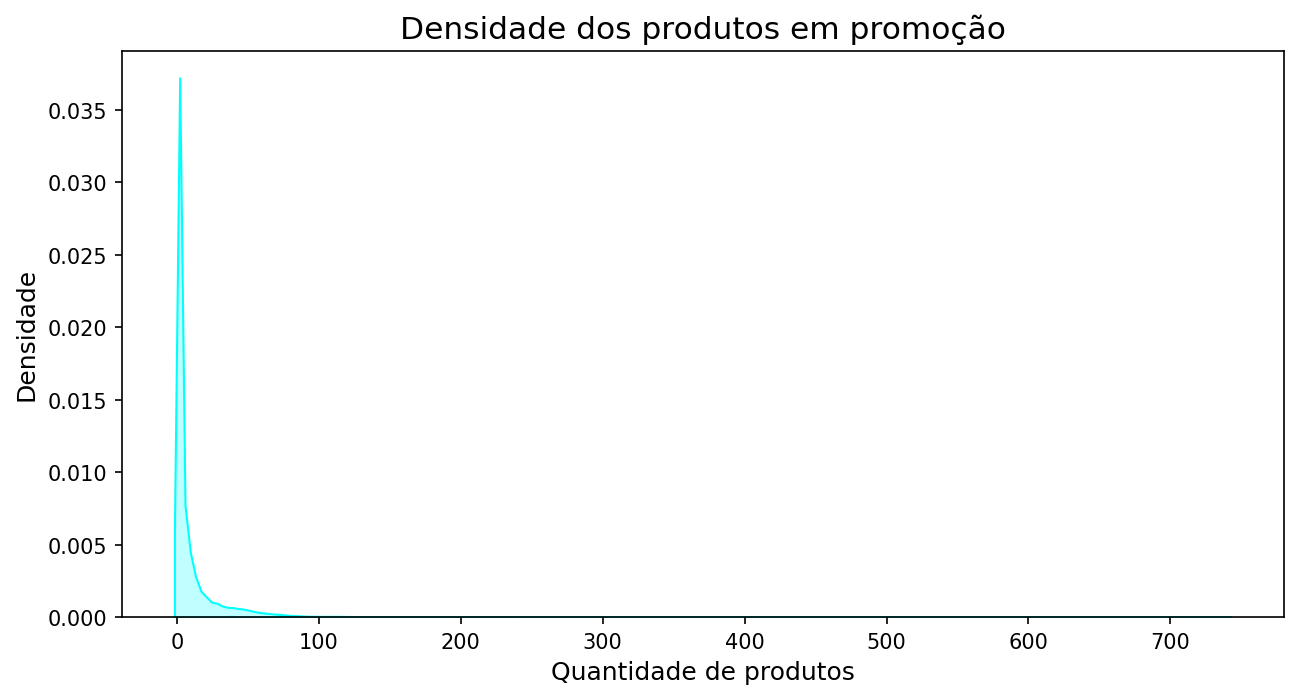

In [14]:
plt.figure(figsize = (10,5), dpi = 150)
sns.kdeplot(data = train_df,
            x = 'onpromotion',
            color = 'cyan',
            shade = True)
plt.title('Densidade dos produtos em promoção', fontsize = 15)
plt.ylabel('Densidade', fontsize = 12)
plt.xlabel('Quantidade de produtos', fontsize = 12);

O gráfico apresenta as seguintes informações: A grande maioria das entradas na base de dado apresenta 0 itens em promoção, porém há uma menor quantidade de itens em promoção.

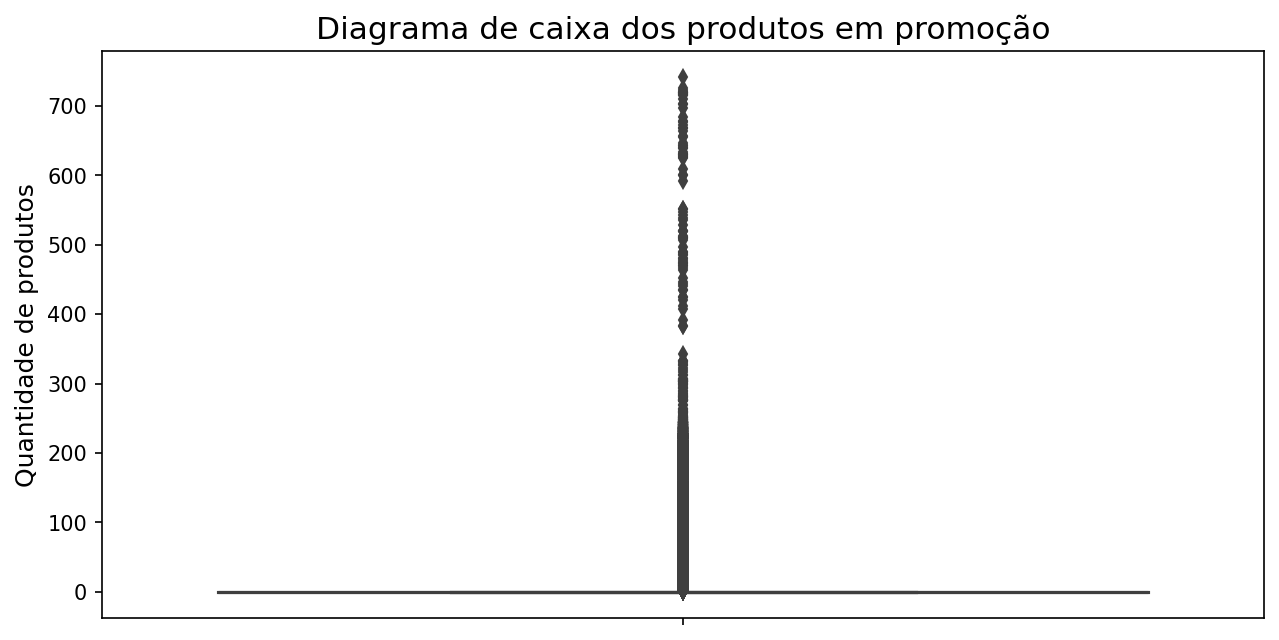

In [15]:
plt.figure(figsize = (10,5), dpi = 150)
sns.boxplot(data = train_df,
            y = 'onpromotion')
plt.ylabel('Quantidade de produtos', fontsize = 12)
plt.title('Diagrama de caixa dos produtos em promoção', fontsize = 15);

O diagrama de caixa confirma as proposições anteriores, a grande maioria das entradas não possuem itens em promoção, porém há uma quantidade expressiva de outliers, que indicam volumes grandes de itens em promoção.

In [16]:
# Agrupando as vendas e produtos em promoção por data:
x_df = train_df[['date','onpromotion','sales']].groupby('date').sum()

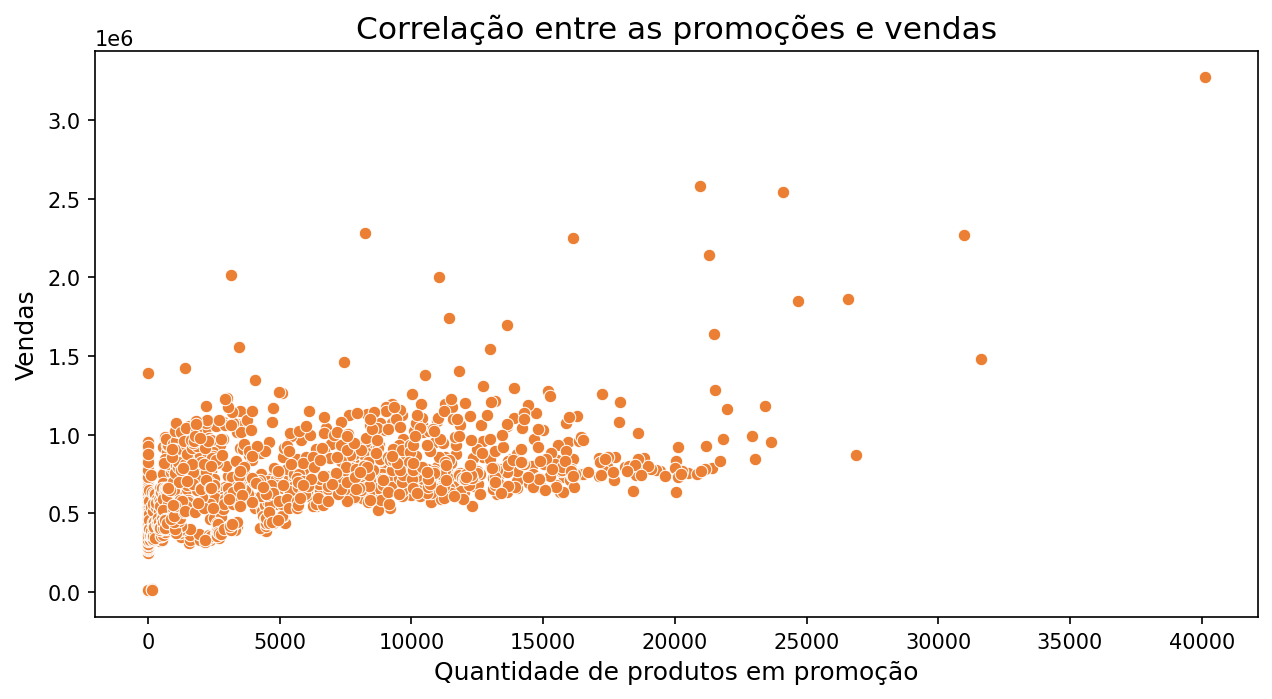

In [17]:
plt.figure(figsize = (10,5), dpi = 150)
sns.scatterplot(data = x_df,
                x = 'onpromotion',
                y = 'sales',
                color = '#eb8034',)
plt.ylabel('Vendas', fontsize = 12)
plt.xlabel('Quantidade de produtos em promoção', fontsize = 12)
plt.title('Correlação entre as promoções e vendas', fontsize = 15);

É possível identificar uma pequena correlação entre as vendas e a quantidade de produtos em promoção, porém há uma quantidade expressiva de outliers.

##### Sales:

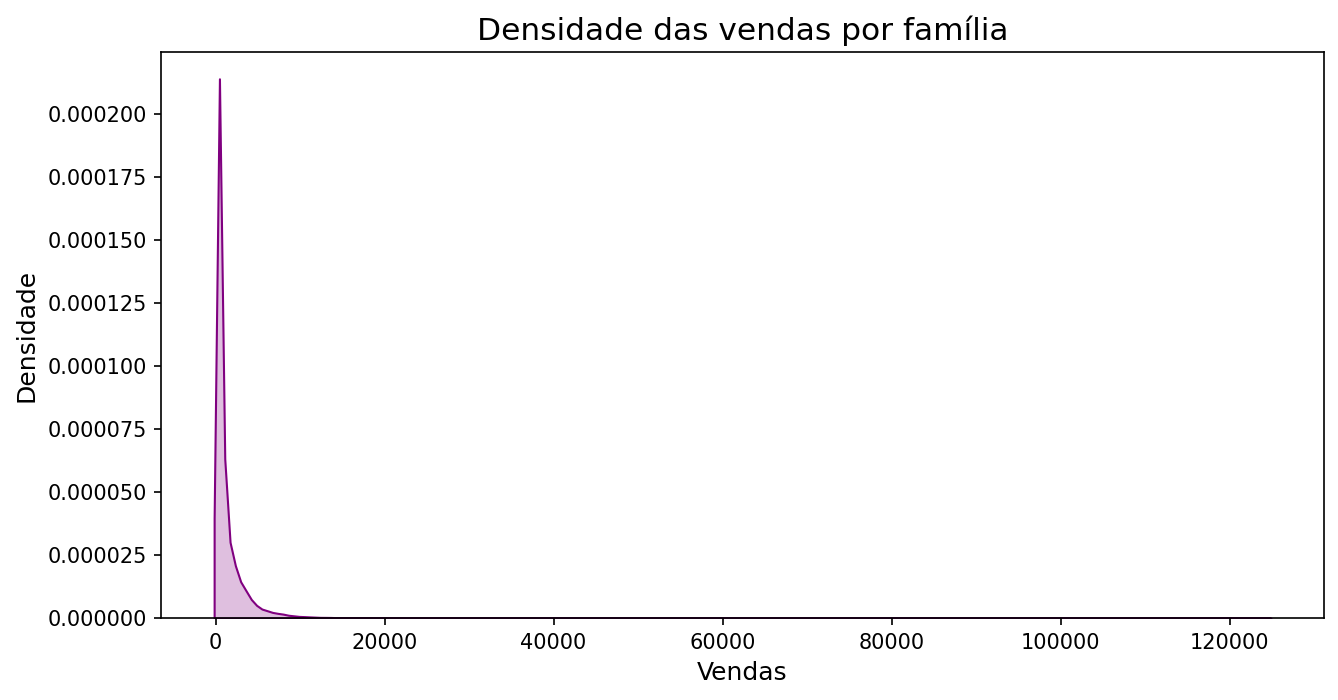

In [18]:
plt.figure(figsize = (10,5), dpi = 150)
sns.kdeplot(data = train_df,
            x = 'sales',
            color = 'purple',
            shade = True)
plt.title('Densidade das vendas por família', fontsize = 15)
plt.ylabel('Densidade', fontsize = 12)
plt.xlabel('Vendas', fontsize = 12);

É possível perceber pela densidade dos dados, que grande parte das vendas por categoria diárias, giram em torno de 0 e uma quantidade menor entre 0 e 10.000, porém a distribuição se extende até 120.000, o que significa que há muitos outliers na série de dados.

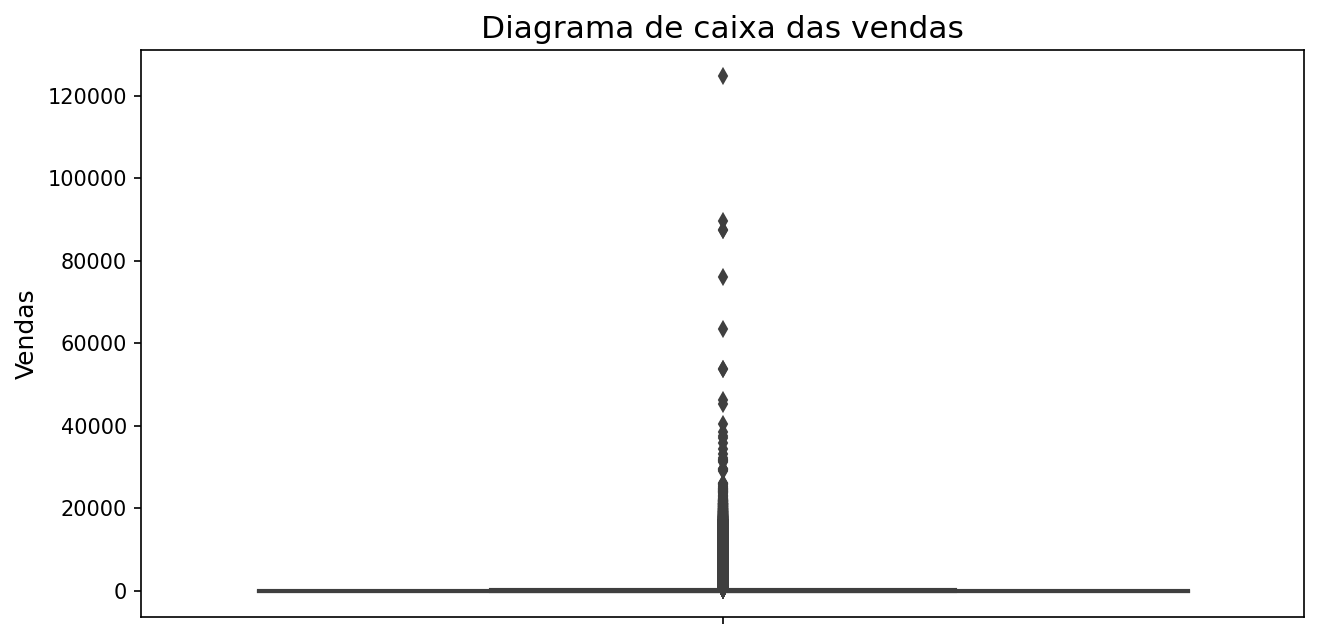

In [19]:
plt.figure(figsize = (10,5), dpi = 150)
sns.boxplot(data = train_df,
            y = 'sales')
plt.ylabel('Vendas', fontsize = 12)
plt.title('Diagrama de caixa das vendas', fontsize = 15);

Esse diagrama de caixa confirma a tese anterior, realmente há uma concentração enorme de dados em 0 e muitos outliers. O que pode levar a problemas em modelos sensíveis a outliers.

In [20]:
# Ajeitando os dados para a visualização das vendas:
date_sales_df = train_df[['date','sales']].groupby('date').sum()
xticks = ['2013-01','2013-06','2013-12',
          '2014-06','2014-12',
          '2015-06','2015-12',
          '2016-06','2016-12',
          '2017-04','2017-8']

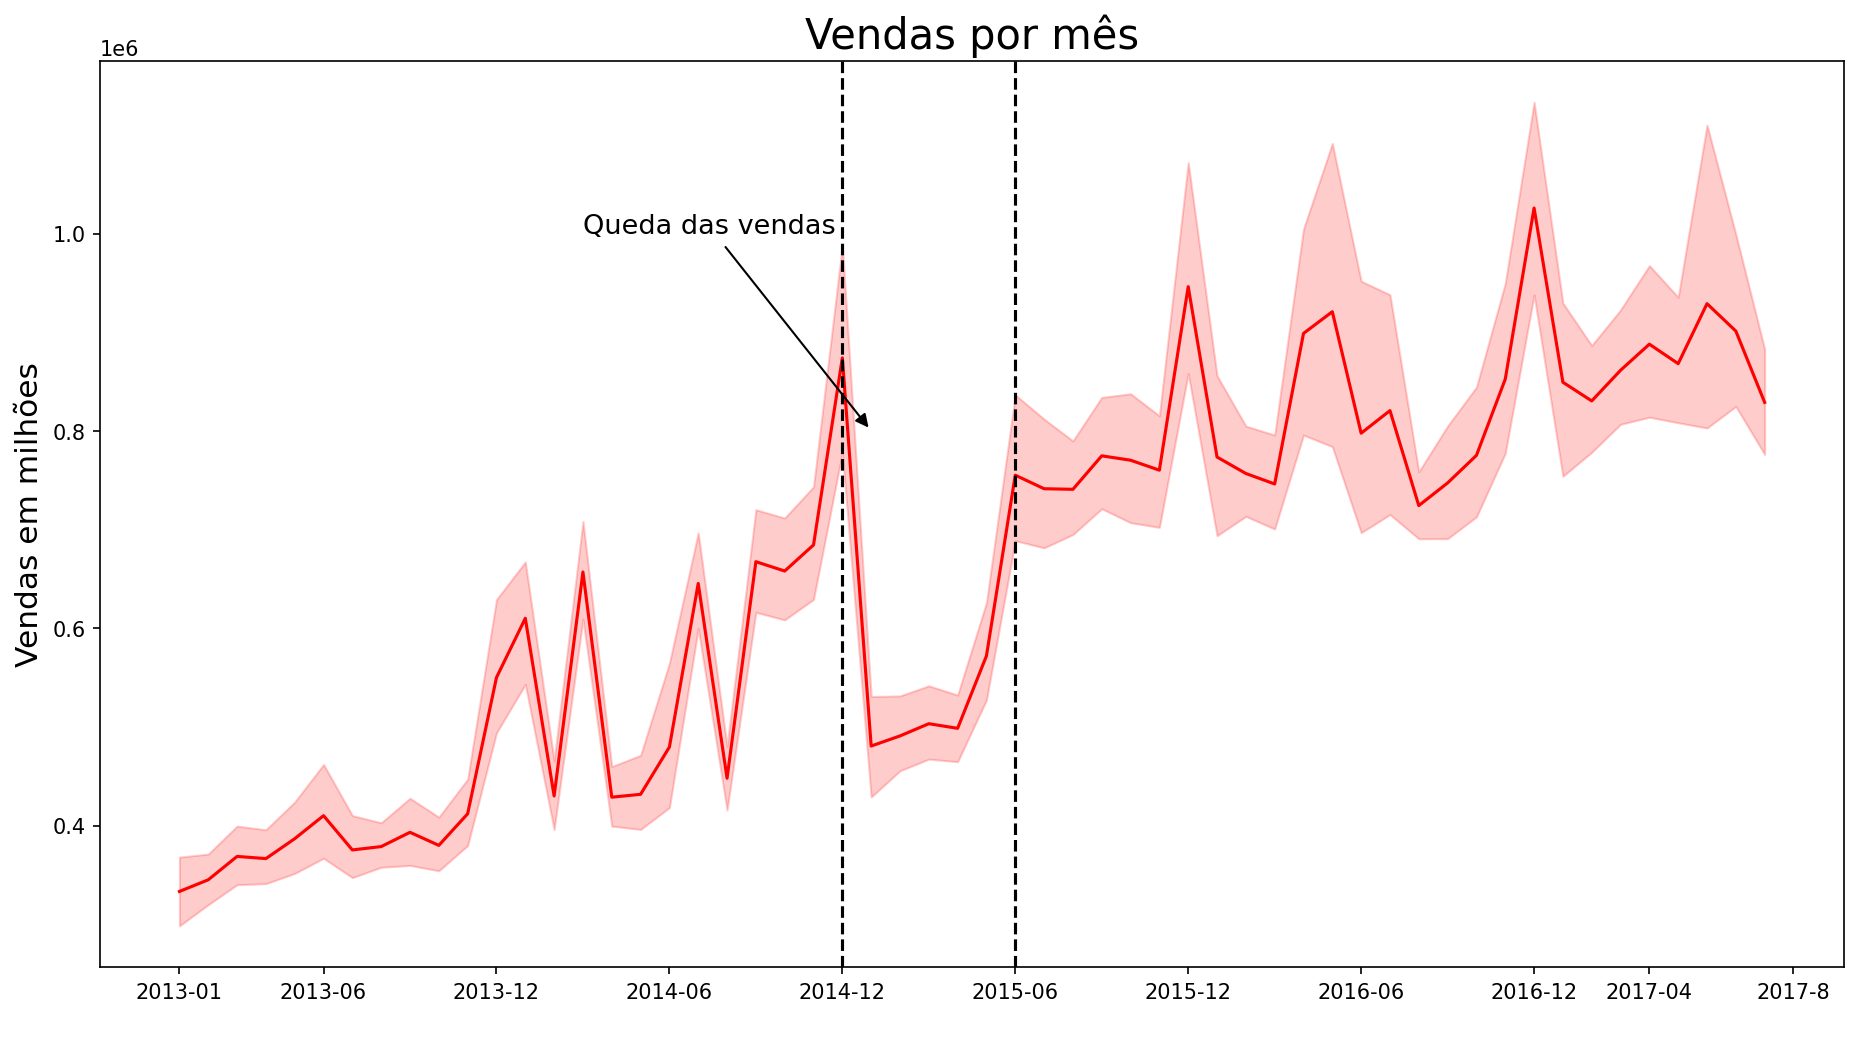

In [21]:
plt.figure(figsize = (15,8), dpi = 150)
sns.lineplot(data = date_sales_df,
             x = date_sales_df.index.str[:7],
             y = 'sales',
             color = 'red')
plt.title('Vendas por mês', fontsize = 20)
plt.ylabel('Vendas em milhões', fontsize = 15)
plt.xlabel(' ')
plt.axvline('2014-12', color = 'black', linestyle = '--')
plt.axvline('2015-06', color = 'black', linestyle = '--')
plt.annotate('Queda das vendas',
             xy = ('2015-01', 800_000), 
             arrowprops = dict(arrowstyle = '-|>',color = 'k'),
             xytext = ('2014-03',1_000_000),
             fontsize = 13)
plt.xticks(xticks);

Através de uma análise na série temporal das vendas, é possível notar uma tendência positiva, embora haja uma oscilação grande de valores, o que denota certa sazonalidade. Dois pontos interessantes nessa série são: uma grande queda de vendas denotada no gráfico e uma queda nas vendas nos meses finais da série, apresentando uma tendência negativa.

##### Dcoilwtico:

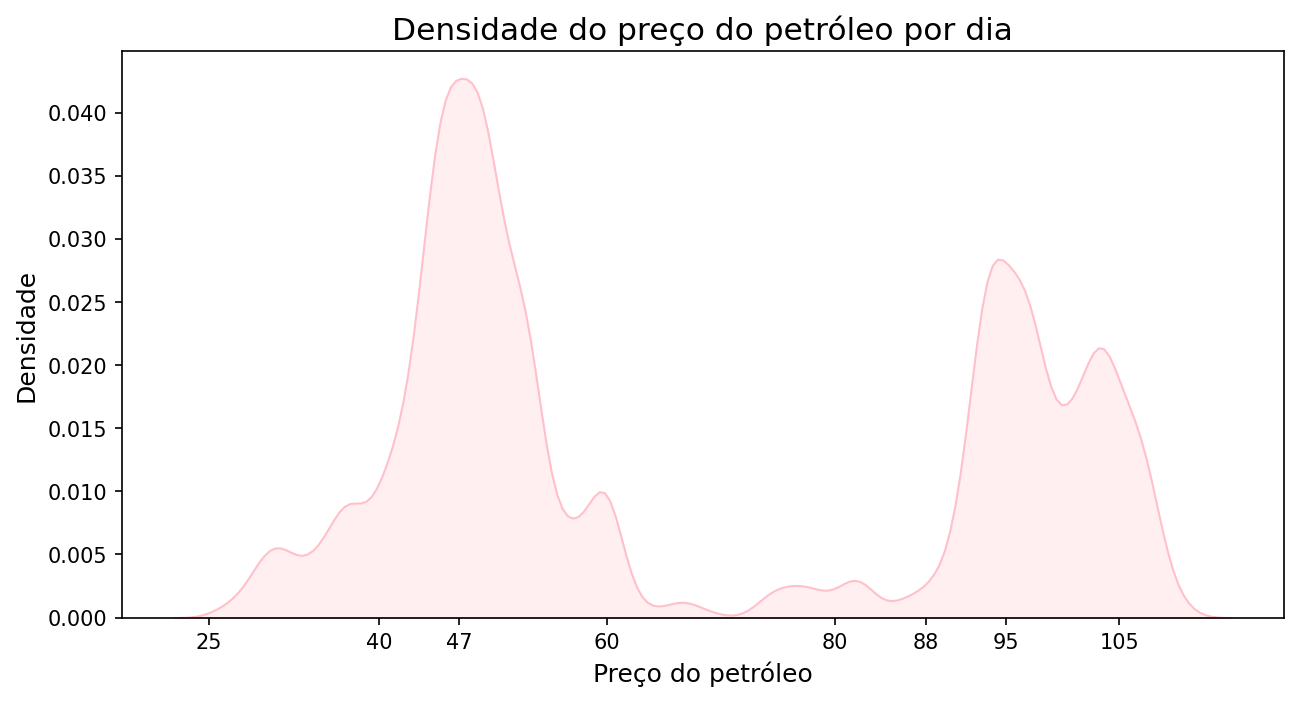

In [22]:
plt.figure(figsize = (10,5), dpi = 150)
sns.kdeplot(data = train_df,
            x = 'dcoilwtico',
            color = 'pink',
            shade = True)
plt.ylabel('Densidade', fontsize = 12)
plt.title('Densidade do preço do petróleo por dia', fontsize = 15)
plt.xlabel('Preço do petróleo', fontsize = 12)
plt.xticks([25,40,47,60,80,88,95,105]);

O preço do petróleo é distribuído de forma singular, sendo concentrado em dois polos, 47 e 95. Há uma grande densidade em torno dos valores entre 40 e 60, com seu pico em 47. E um segundo foco em 95, variando entre 88 e 105. Os outros intervalos apresentam uma densidade pequena, o que indica um deslocamento expressivo do preço do petróleo.

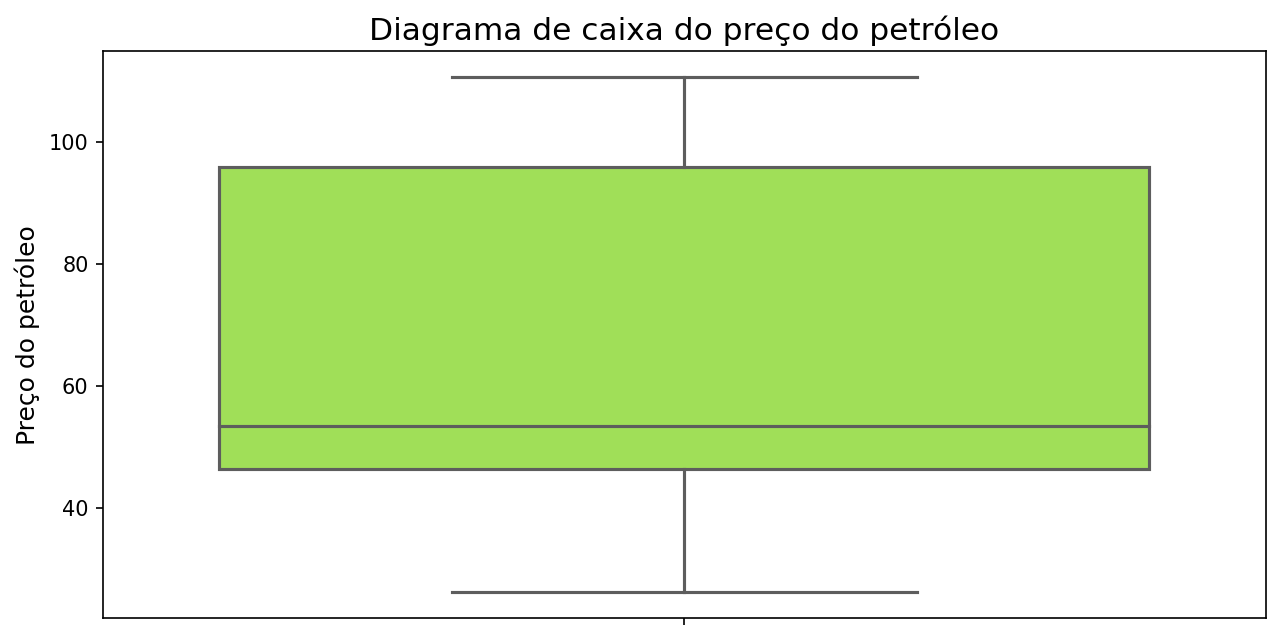

In [23]:
plt.figure(figsize = (10,5), dpi = 150)
sns.boxplot(data = train_df,
            y = 'dcoilwtico',
            color = '#a1f542')
plt.ylabel('Preço do petróleo', fontsize = 12)
plt.title('Diagrama de caixa do preço do petróleo', fontsize = 15);

O diagrama de caixa do preço do petróleo, mostra uma grande concentração dos dados, entre aproximadamente 50 e 90. O ponto mais importante é que não há outliers no gráfico, nem indicações de uma grande dispersão. 

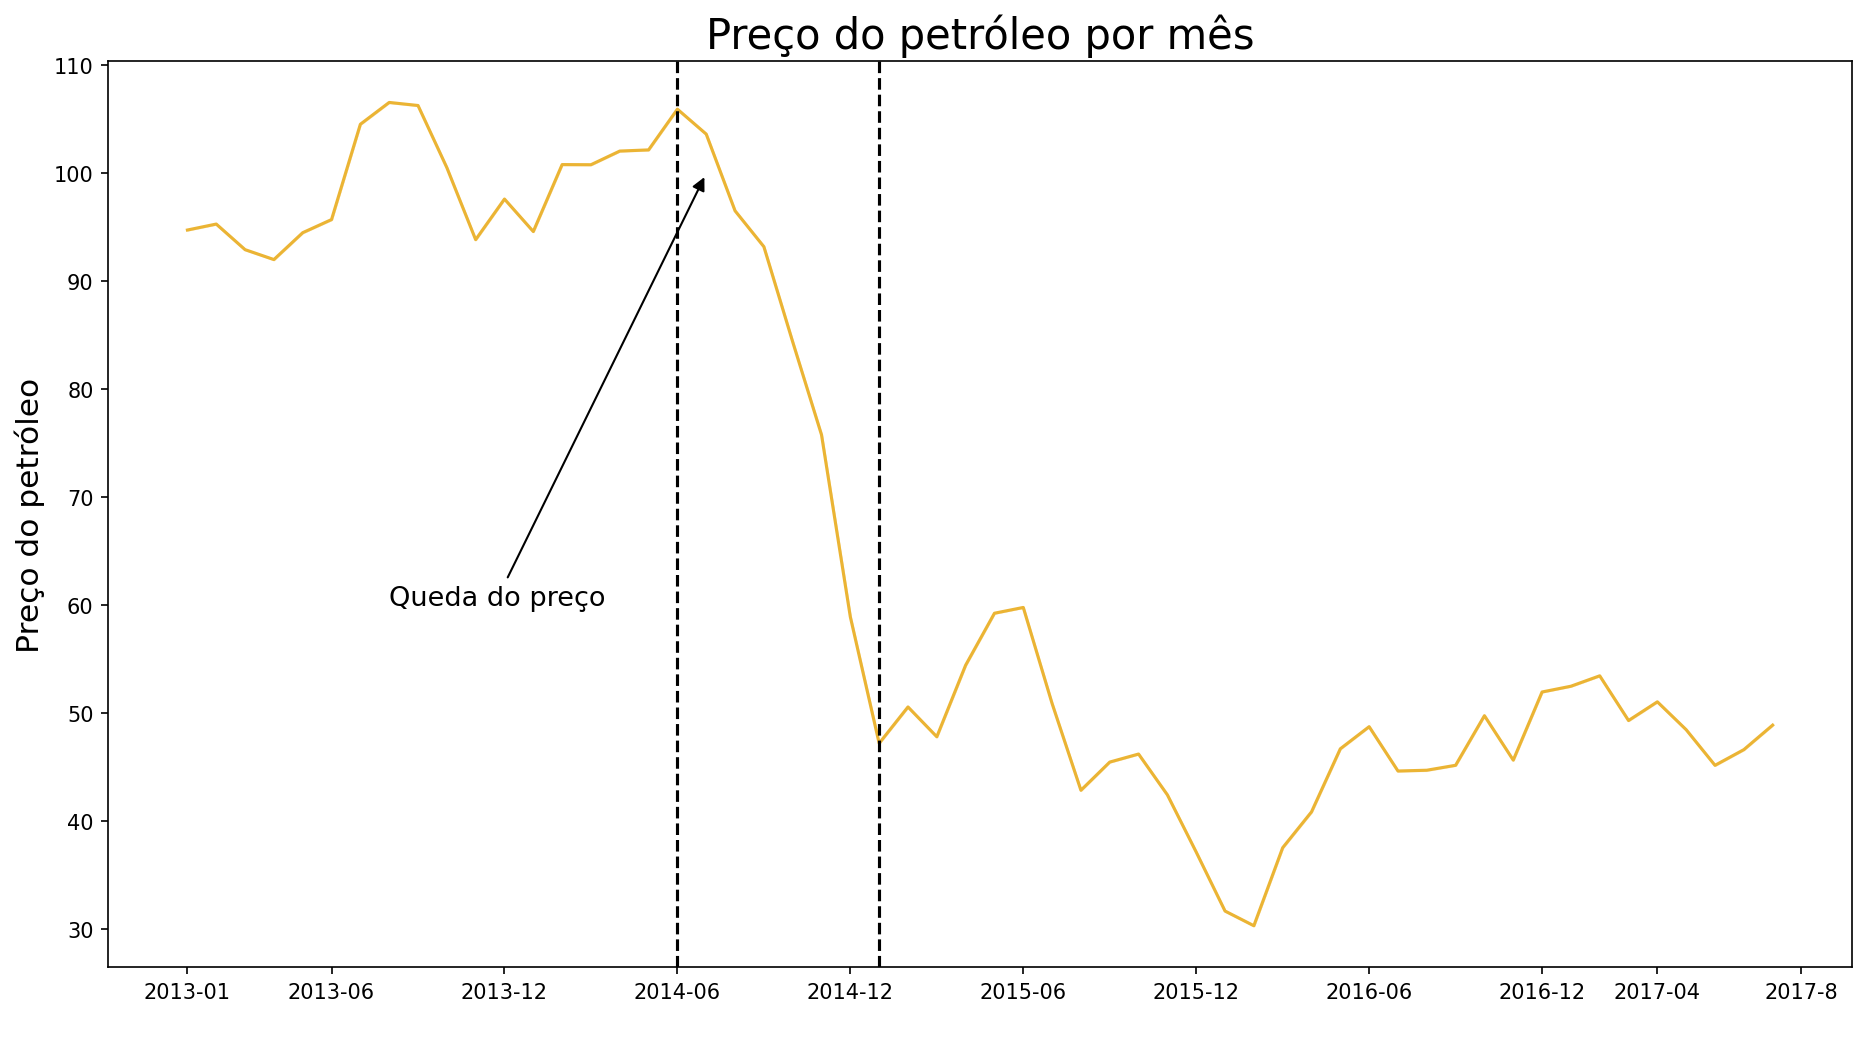

In [24]:
plt.figure(figsize = (15,8), dpi = 150)
sns.lineplot(data = train_df,
             x = train_df['date'].str[:7],
             y = 'dcoilwtico',
             color = '#ebb434')
plt.axvline('2014-06', color = 'black', linestyle = '--')
plt.axvline('2015-01', color = 'black', linestyle = '--')
plt.title('Preço do petróleo por mês', fontsize = 20)
plt.ylabel('Preço do petróleo', fontsize = 15)
plt.xlabel(' ')
plt.annotate('Queda do preço',
             xy = ('2014-07', 100), 
             arrowprops = dict(arrowstyle = '-|>',color = 'k'),
             xytext = ('2013-08',60),
             fontsize = 13)
plt.xticks(xticks);

As alterações do preço do petróleo ao longo do tempo comprovam a hipótese anterior, de fato houve um deslocamento da média de preços, que ocorreu graças a uma grande desvalorização no preço. Um ponto importante é que essa grande queda do preço do petróleo precede a queda das vendas, baseado no fato que o Equador é um país com forte dependência econômica no petróleo, é possível teorizar que esse pode ter sido o motivo da queda de vendas, o atraso da queda de vendas é um processo econômico comum, muitas vezes há uma demora para a reação dos agentes econômicos quanto as mudanças na economia.

#### Junção dos gráficos:

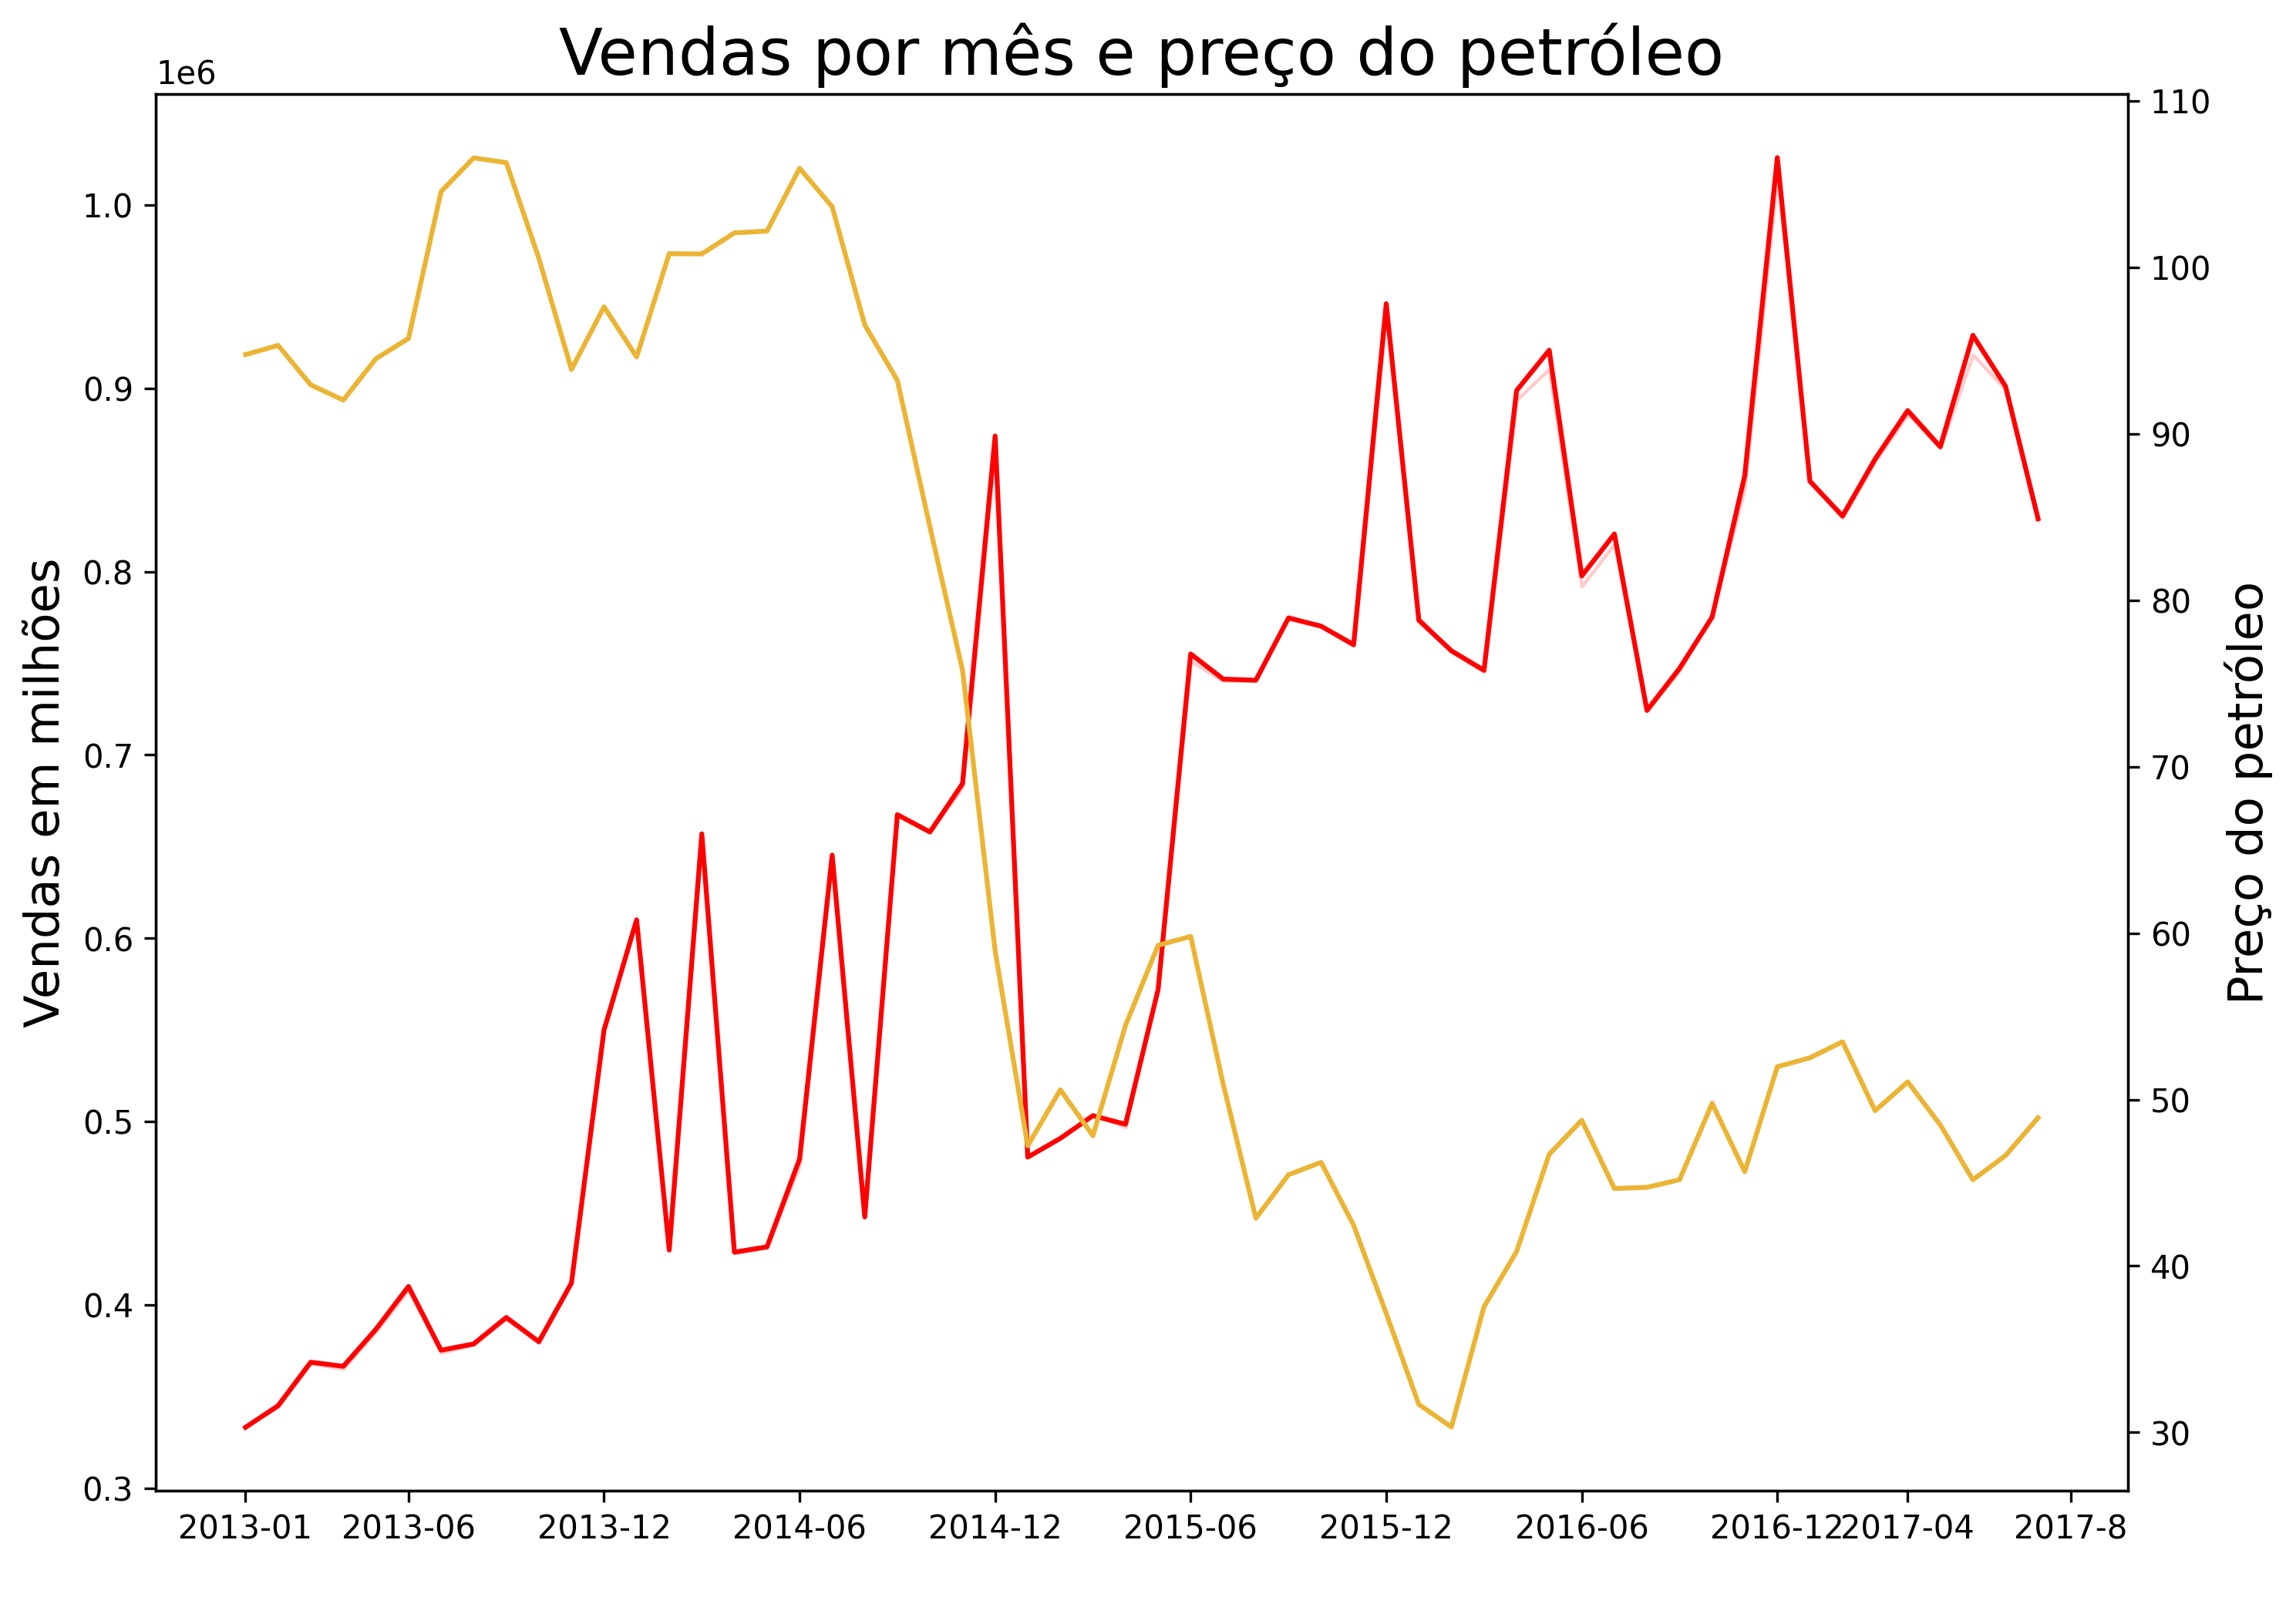

In [25]:
plt.figure(figsize=(11,8), dpi = 300)
sns.lineplot(data = date_sales_df,
             x = date_sales_df.index.str[:7],
             y = 'sales',
             color = 'red',
             ci = 0)
plt.title('Vendas por mês e preço do petróleo', fontsize = 20)
plt.ylabel('Vendas em milhões', fontsize = 15)
plt.xlabel(' ')
ax2 = plt.twinx()
sns.lineplot(data = train_df,
             x = train_df['date'].str[:7],
             y = 'dcoilwtico',
             color = '#ebb434')
plt.ylabel('Preço do petróleo', fontsize = 15)
plt.xlabel(' ')
plt.xticks(xticks);

Esse gráfico conjunto comprova a ideia anterior, de fato a queda das vendas foi precedida pela diminuição do preço do petróleo, que provavelmente gerou um impacto negativo muito grande na economia do Equador, porém as vendas voltaram a crescer após o impacto inicial, enquanto o preço do petróleo se estabilizou em um patamar mais baixo.

#### Features categóricas:

##### Family:

In [26]:
family_gb = train_df[['family','sales']].groupby('family').mean()
family_gb.sort_values('sales', ascending = False, inplace = True)

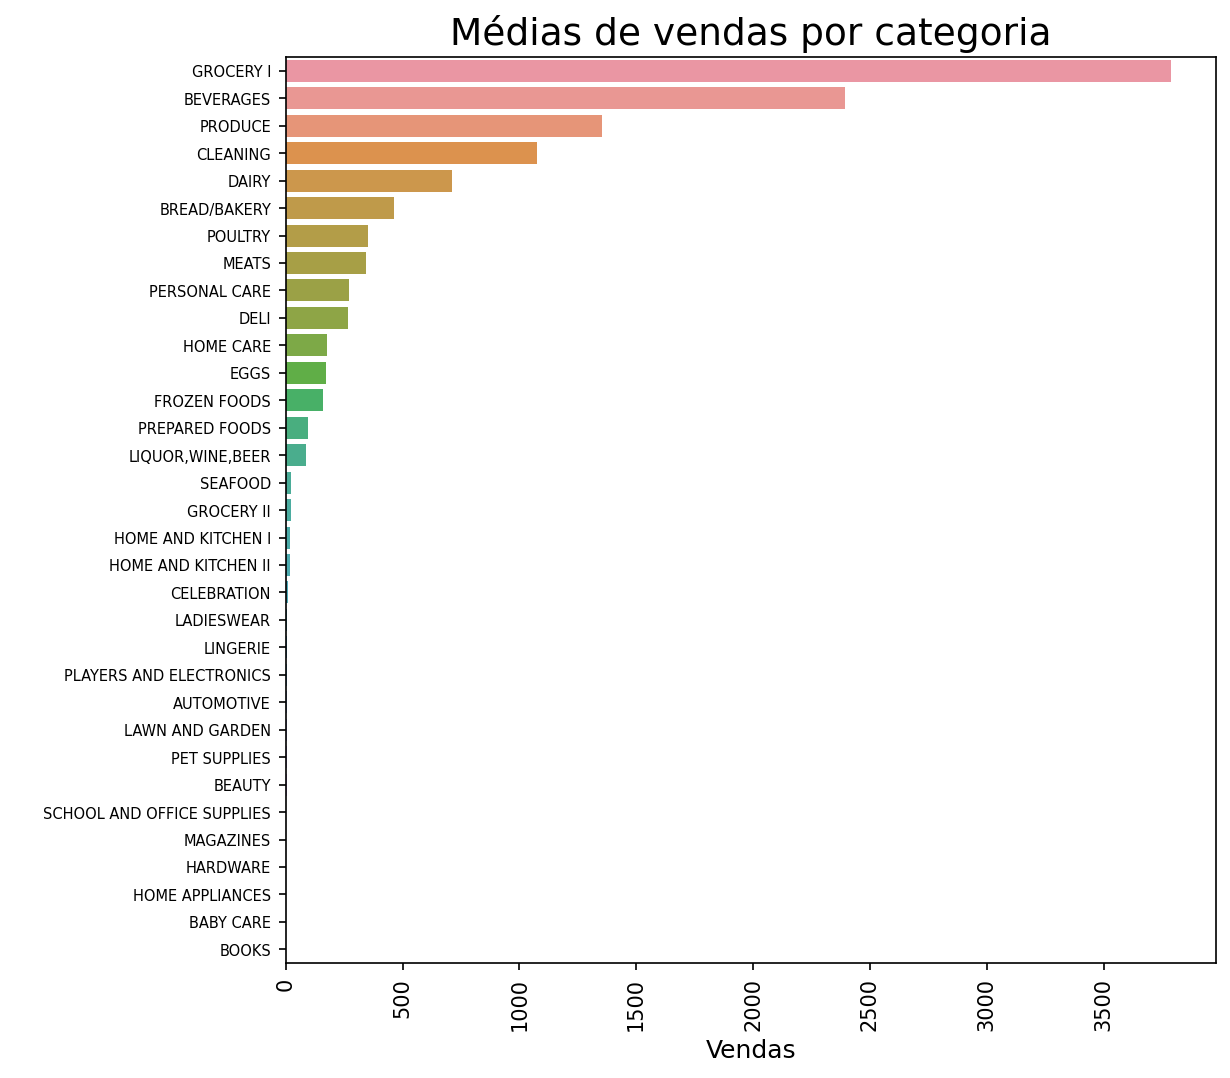

In [27]:
plt.figure(figsize = (8,8), dpi = 150)
sns.barplot(data = family_gb,
            y = family_gb.index,
            x = 'sales')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Médias de vendas por categoria', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12)
plt.yticks(fontsize = 7);

O gráfico mostra que uma grande parte das famílias de produtos tem uma média de vendas muito baixa, portanto é possível deduzir que a empresa é altamente dependente de poucas categorias, visto que há uma grande concentração de vendas em poucas famílias, uma quantidade maior com vendas medianas, e praticamente metade com vendas pequenas.

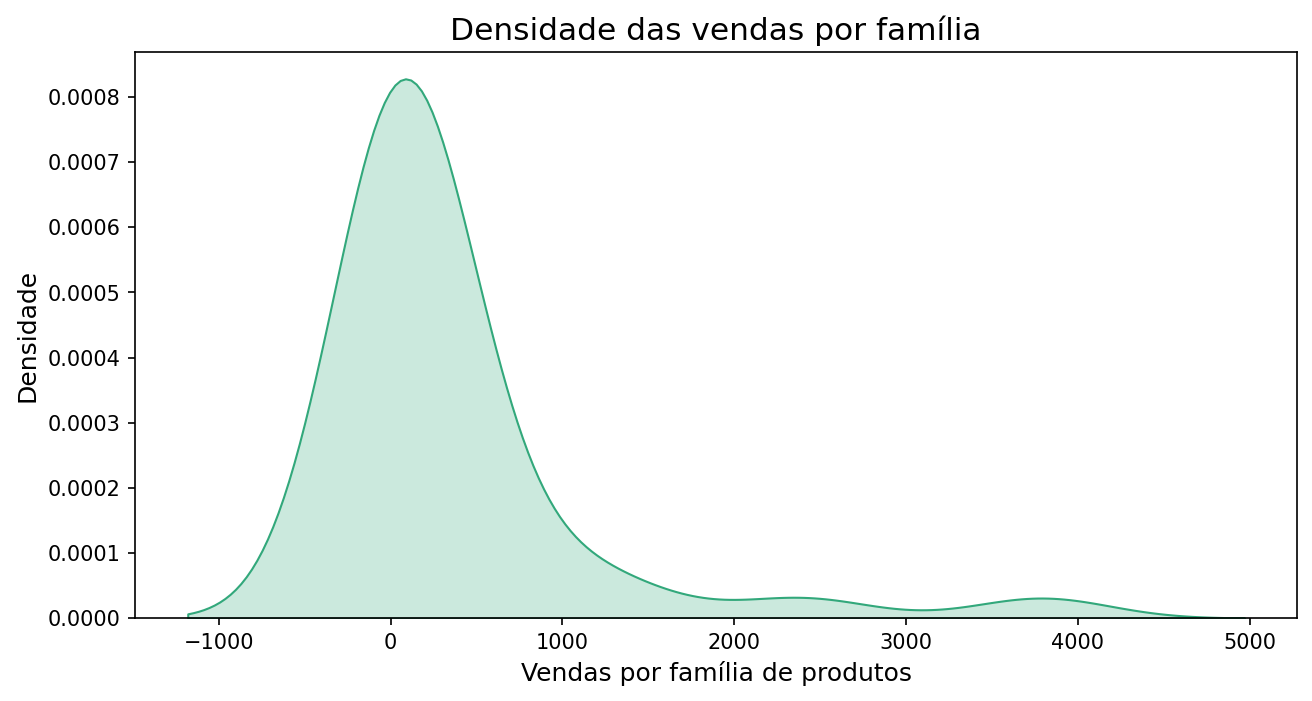

In [28]:
plt.figure(figsize = (10,5), dpi = 150)
sns.kdeplot(family_gb['sales'],
            color = '#32a87b',
            shade = True)
plt.ylabel('Densidade', fontsize = 12)
plt.xlabel('Vendas por família de produtos', fontsize = 12)
plt.title('Densidade das vendas por família', fontsize = 15);

A densidade dos dados apresenta uma forte concentração em torno de 0, que comprova a ideia anterior de que uma grande parte das famílias de produtos tem uma média de vendas muito pequena, porém a calda direita da distribuição se estende até a casa de 4500, o que mostra a pequena quantidade de categorias com uma média de vendas alta.

##### City:

In [29]:
city_gb = train_df[['city','sales']].groupby('city').mean()
city_gb.sort_values('sales', ascending = False, inplace = True)

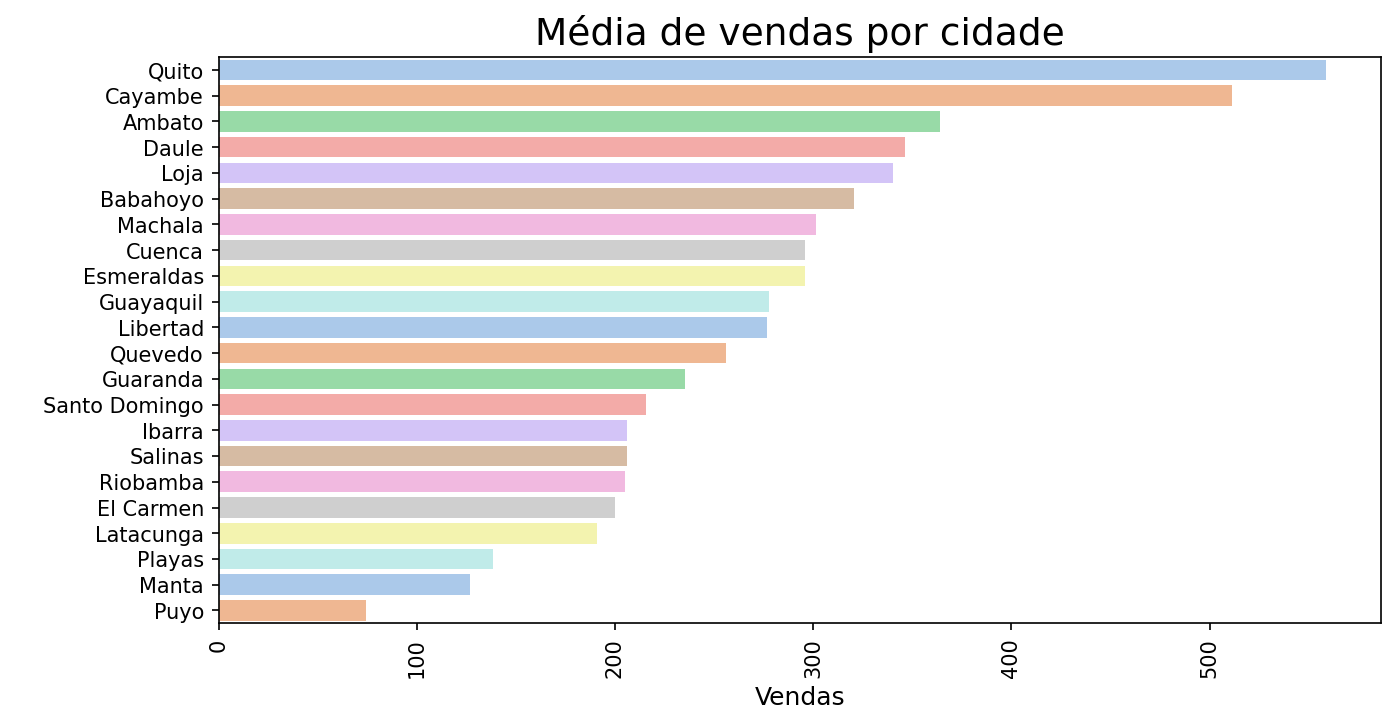

In [30]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = city_gb,
            y = city_gb.index,
            x = 'sales',
            palette = 'pastel')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas por cidade', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

É possível notar que não há grandes discrepâncias no gráfico, fora alguns valores em particular. A grande maioria das cidades apresenta uma média de vendas semelhante, com excessão de Quito e Cayambe positivamente, e Puyo negativamente.

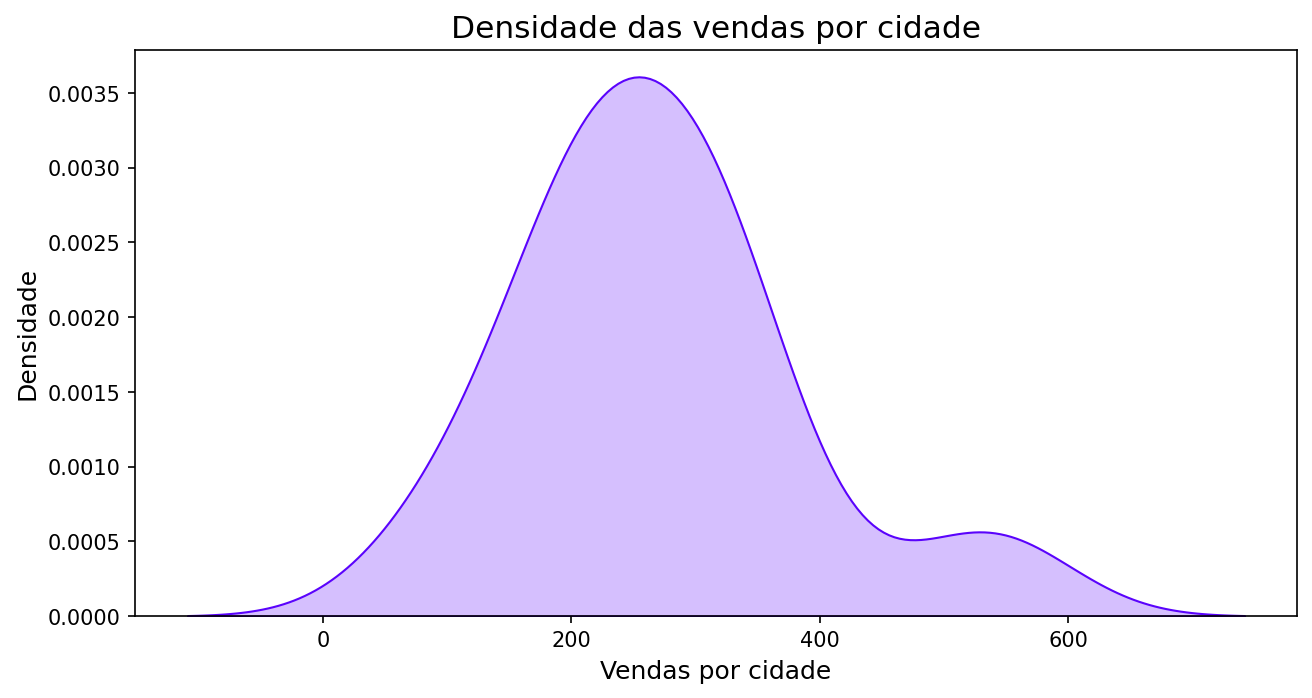

In [31]:
plt.figure(figsize = (10,5), dpi = 150)
sns.kdeplot(city_gb['sales'],
            color = '#5a03fc',
            shade = True)
plt.ylabel('Densidade', fontsize = 12)
plt.xlabel('Vendas por cidade', fontsize = 12)
plt.title('Densidade das vendas por cidade', fontsize = 15);

Atráves do gráfico da densidade de vendas das cidades, é possível concluir que de fato os valores não são dispersos, sendo o gráfico muito similar a uma distribuição T-Student. A informação mais interessante apresentada por esse gráfico é uma distorção a direita da distribuição, que indica uma densidade maior de valores entre 400 e 600 do que na outra calda da distribuição, portanto quando há valores distantes da média, eles tendem a serem maiores e não menores. 

##### Type_store:

In [32]:
store_gb = train_df[['type_store','sales']].groupby('type_store').mean()
store_gb.sort_values('sales', ascending = False, inplace = True)

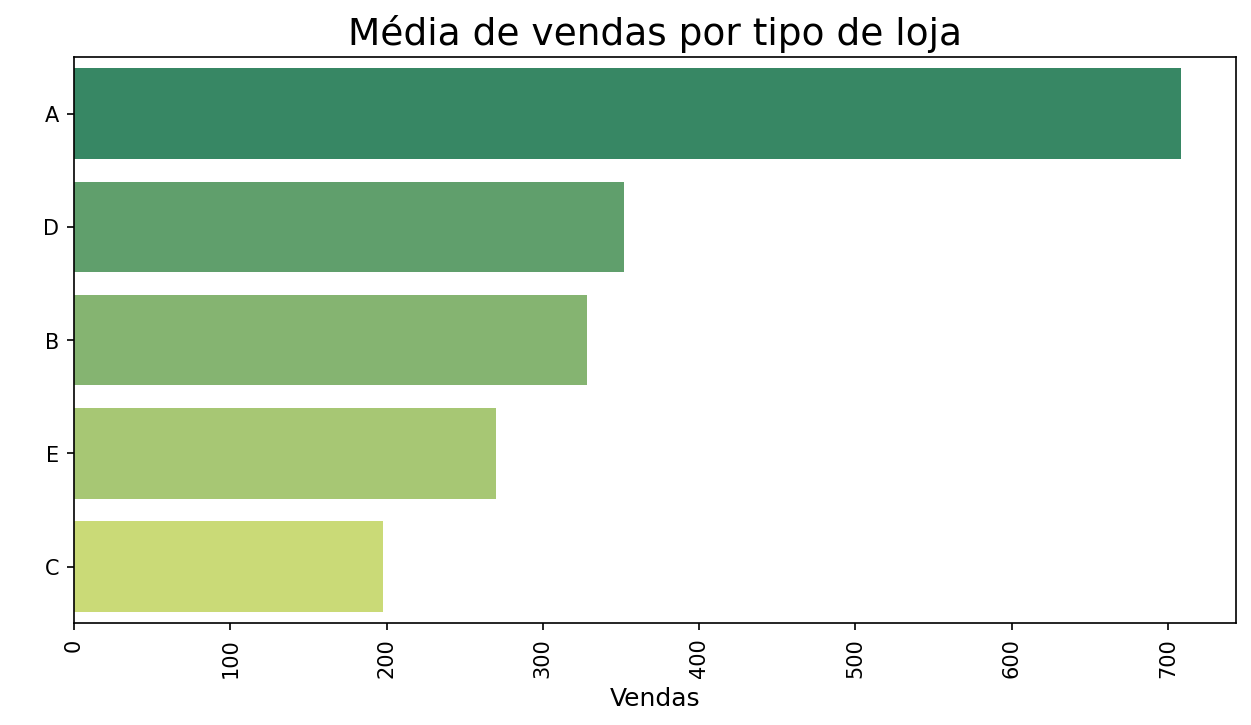

In [33]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = store_gb,
            y = store_gb.index,
            x = 'sales',
            palette = 'summer')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas por tipo de loja', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

O tipo de loja A evidentemente tem uma média de vendas muito melhor que as demais, já D, B e E tem uma média de vendas semelhante, e C apresenta uma média pior que a das outras lojas.

##### Cluster:

In [34]:
cluster_gb = train_df[['cluster','sales']].groupby('cluster').mean()
cluster_gb.sort_values('sales', ascending = False, inplace = True)

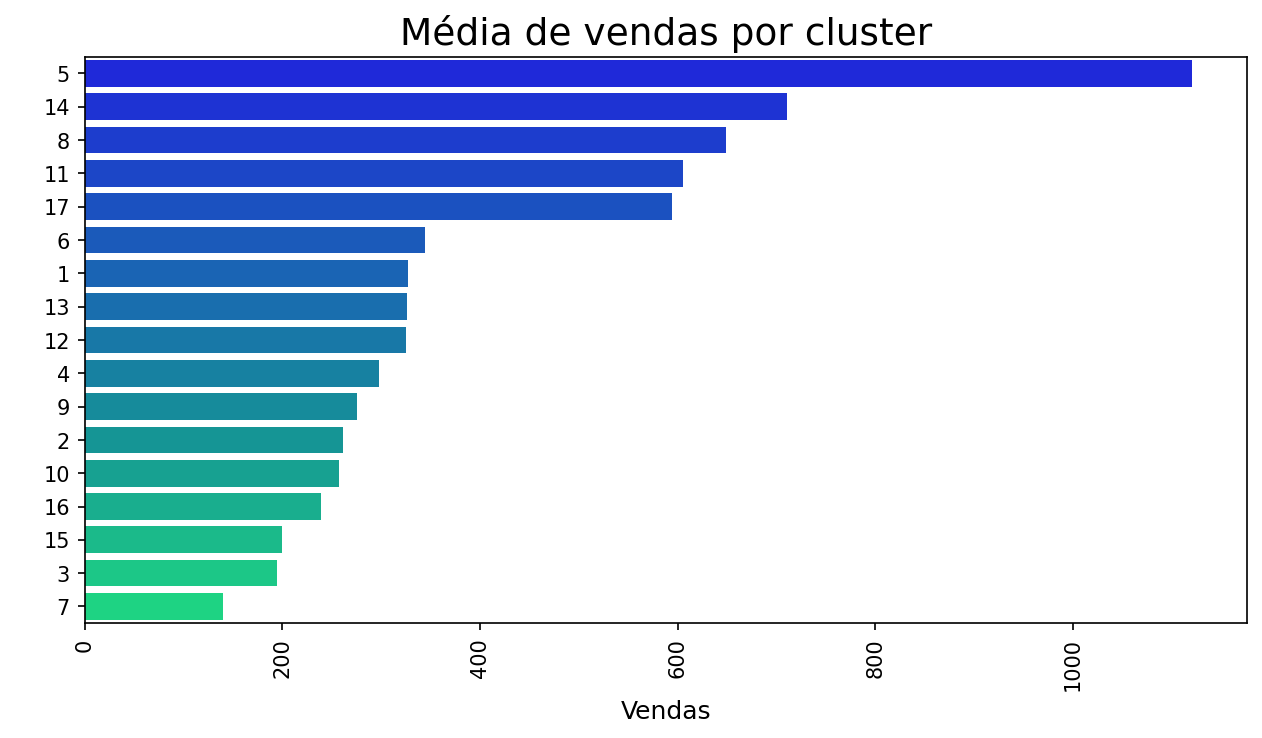

In [35]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = cluster_gb,
            y = cluster_gb.index.astype(str),
            x = 'sales',
            palette = 'winter')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas por cluster', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

Os cluster 5, 14, 8 e 11, tem uma média de vendas muito maior dos que os outros, e 7, 3, 15, 16, possuem uma média muito menor, enquanto os outros apresentam uma média semelhante.

##### Type_holiday:

In [36]:
# Capturando os valores nulos:
train_df['type_holiday'].fillna('Normal day', inplace = True)

In [37]:
holy_gb = train_df[['type_holiday','sales']].groupby('type_holiday').mean()
holy_gb.sort_values('sales', ascending = False, inplace = True)

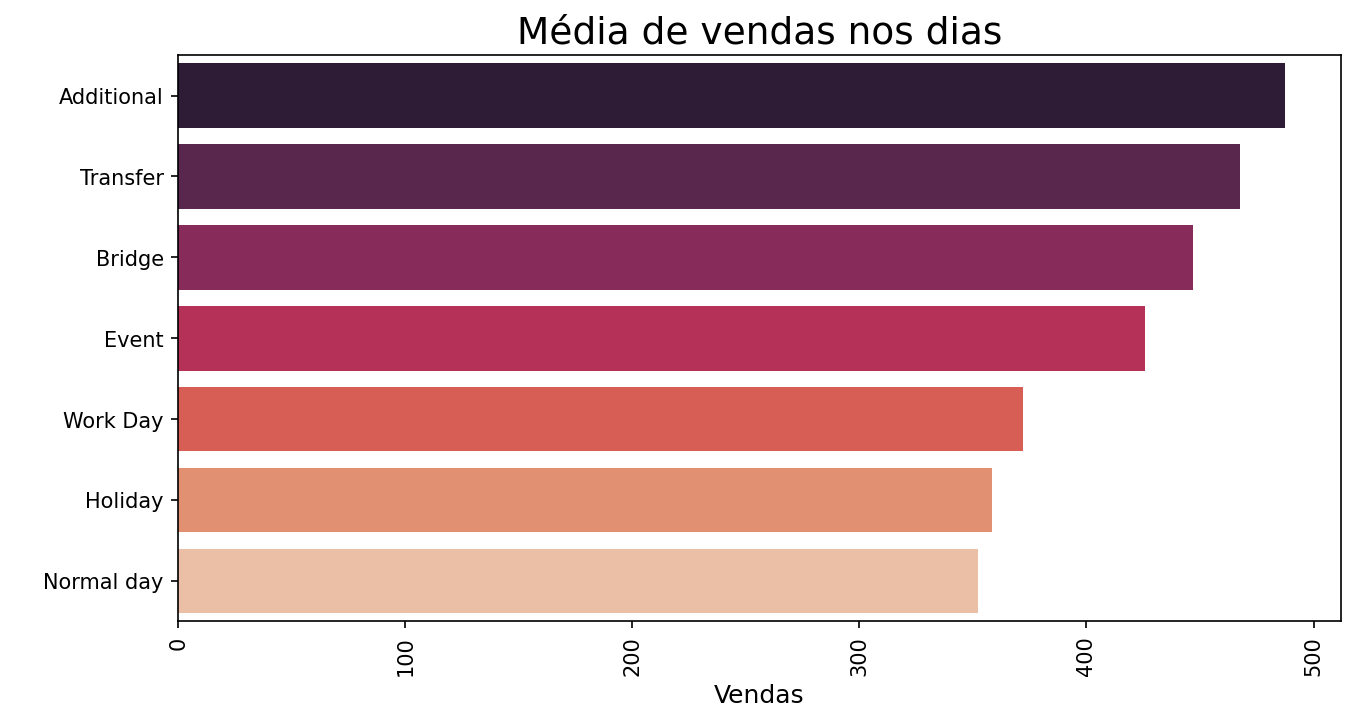

In [38]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = holy_gb,
            y = holy_gb.index,
            x = 'sales',
            palette = 'rocket')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas nos dias', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

Quando é um feriado, independe de qual seja, há um aumento da média de vendas mesmo que pequeno. Porém as diferenças não são muito discrepantes.

##### Locale:

In [39]:
locale_gb = train_df[['locale','sales']].groupby('locale').mean()
locale_gb.sort_values('sales', ascending = False, inplace = True)

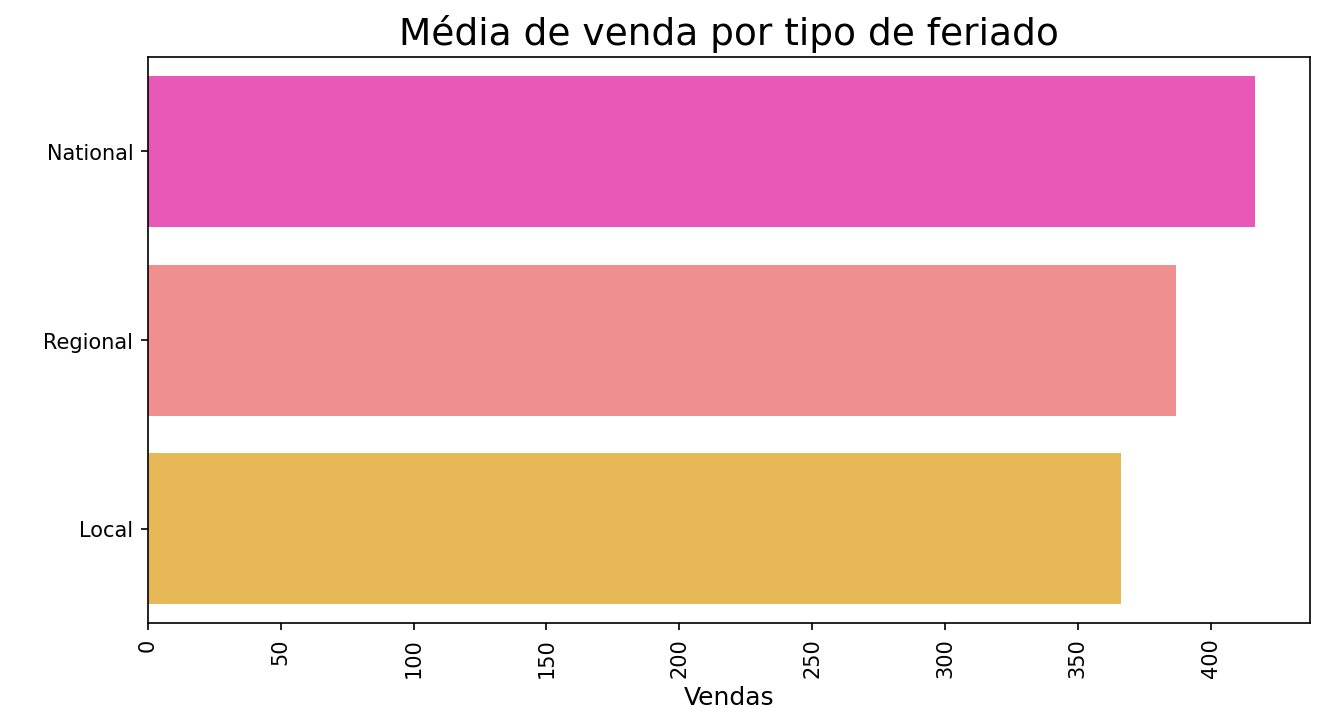

In [40]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = locale_gb,
            y = locale_gb.index,
            x = 'sales',
            palette = 'spring')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de venda por tipo de feriado', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

É possível perceber uma hierarquia dos feriados, partindo de local para regional e por fim nacional, aumentando a escala da área conforme as categorias mudam, havendo um pequeno aumento na média de vendas com o avanço da categoria.

##### Locale_name:

In [41]:
name_gb = train_df[['locale_name','sales']].groupby('locale_name').mean()
name_gb.sort_values('sales', ascending = False, inplace = True)

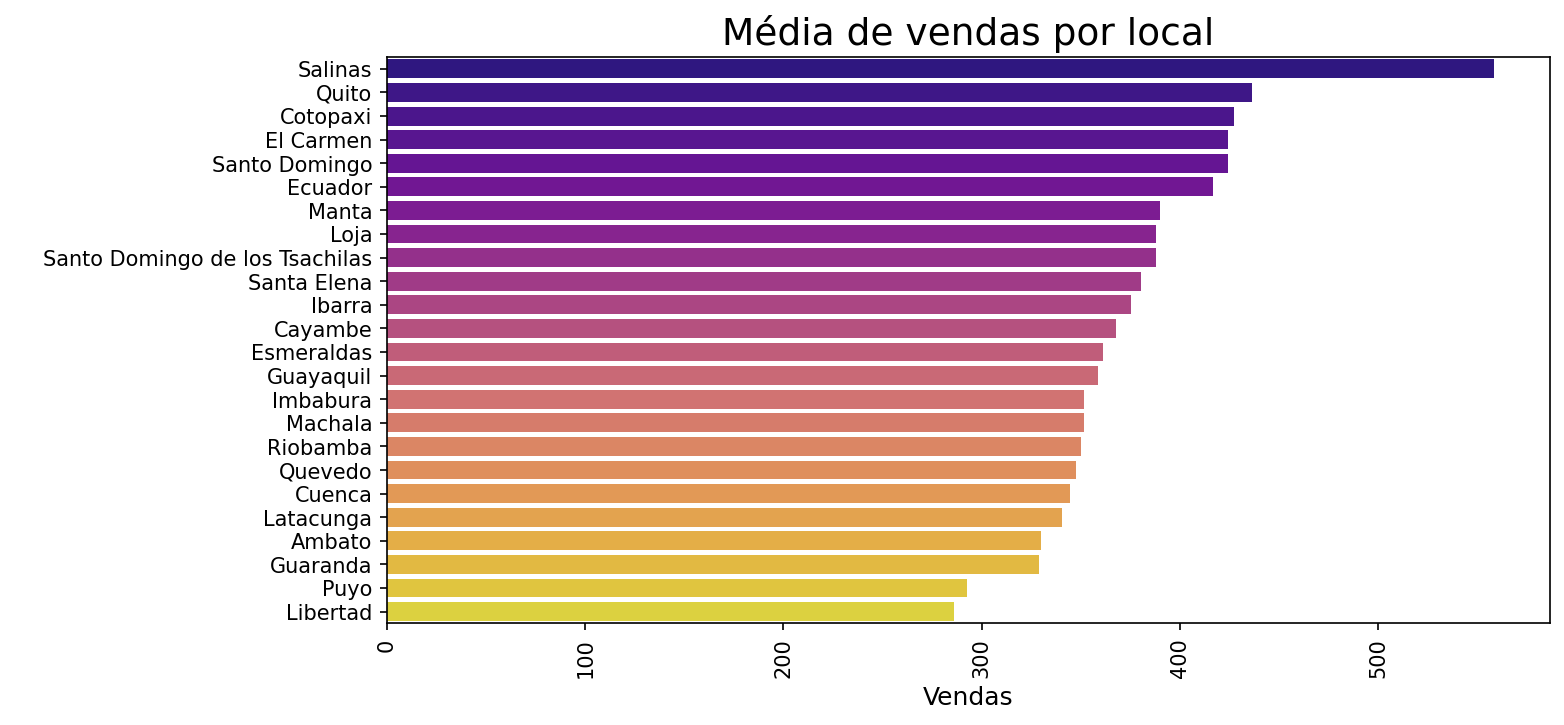

In [42]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = name_gb,
            y = name_gb.index,
            x = 'sales',
            palette = 'plasma')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas por local', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

Retirando Salinas, basicamente todos os outros nomes de locais apresentam uma média próxima de vendas. Já Salinas apresenta uma média muito maior do que os demais, um fato intrigante visto que na média de vendas por cidades, Salinas demonstrou uma média de vendas baixas, o que denota uma sensibilidade maior a feriados nesse local, ou outro fator ainda não esclarecido.  

##### Transferred:

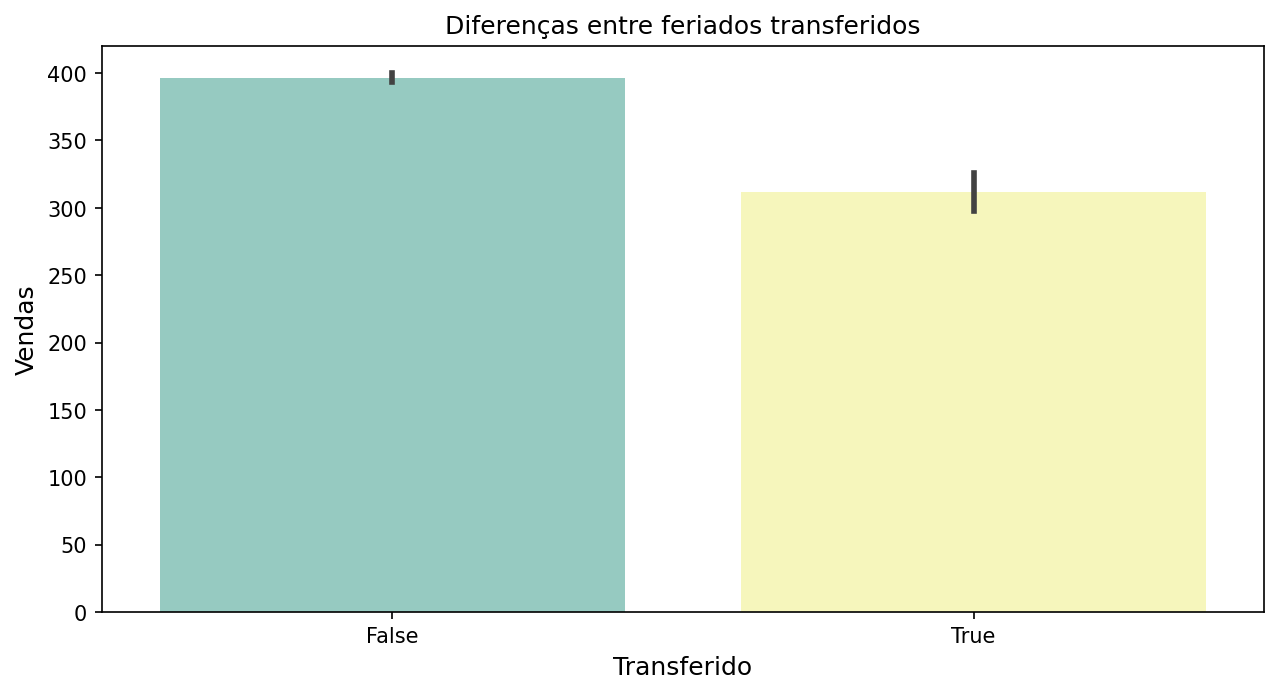

In [43]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = train_df,
            x = 'transferred',
            y = 'sales',
            palette = 'Set3')
plt.xlabel('Transferido', fontsize = 12)
plt.ylabel('Vendas', fontsize = 12)
plt.title('Diferenças entre feriados transferidos');

É claro que quando os feriados transferidos tem uma média de vendas menor.

##### Store_nbr:

In [44]:
# Agregando os dados:
store_nbr_gb = train_df[['store_nbr','sales']].groupby('store_nbr').mean()
store_nbr_gb.sort_values('sales', ascending = False, inplace = True)

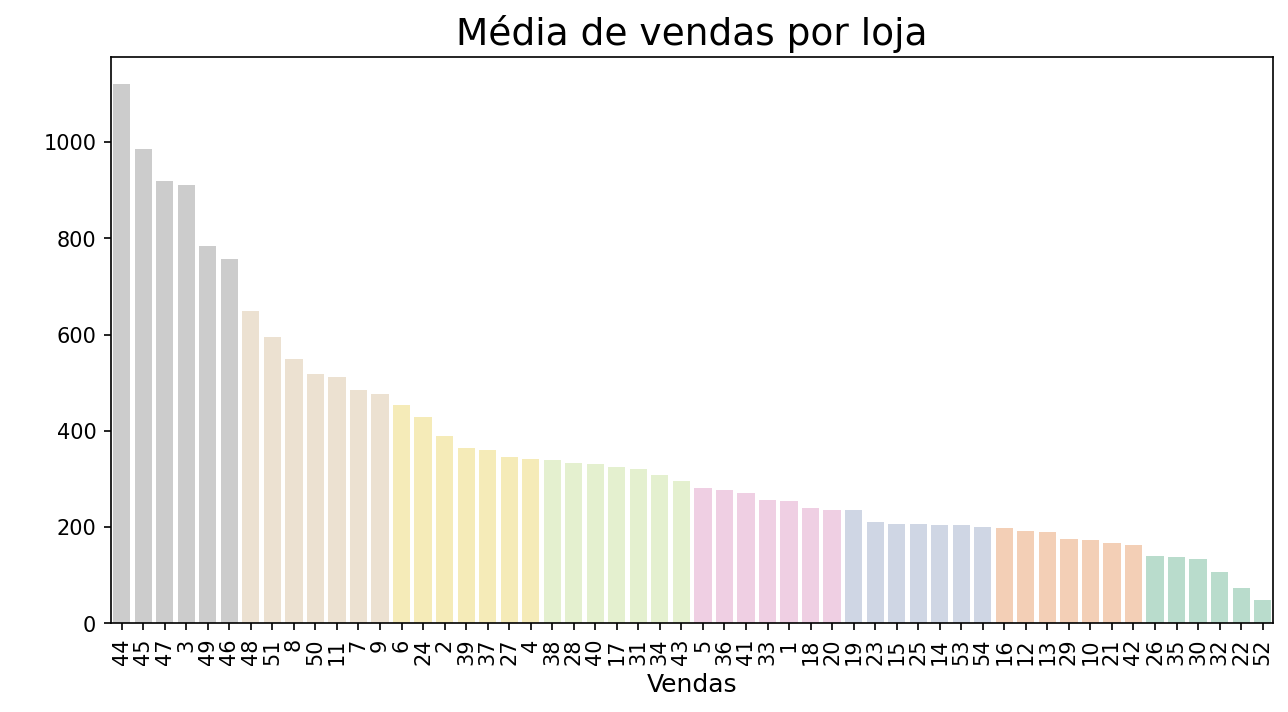

In [45]:
plt.figure(figsize = (10, 5), dpi = 150)
sns.barplot(data = store_nbr_gb,
            x = store_nbr_gb.index.astype(str),
            y = 'sales',
            palette = 'Pastel2_r')
plt.xticks(rotation = 'vertical')
plt.ylabel(' ')
plt.title('Média de vendas por loja', fontsize = 18)
plt.xlabel('Vendas', fontsize = 12);

É possível identificar a diferença de vendas entre as lojas, apesar de não haver relações claras com a numeração de cada uma, as diferenças de vendas tem expressiva discrepância, enquanto a média de vendas das menores lojas é de cerca de 200, nas maiores é cerca de 1000.

## Parte 3 - Feature Engineering:

### Separando a base de dados:

In [46]:
n_cols = ['onpromotion','dcoilwtico']
cat_cols = ["store_nbr", 'family','city','state','type_store','cluster','type_holiday','locale','locale_name','transferred']

### Tratando os valores nulos:

In [47]:
# % de valores nulos:
train_df.isna().mean()

id              0.000000
date            0.000000
store_nbr       0.000000
family          0.000000
sales           0.000000
onpromotion     0.000000
dcoilwtico      0.312719
city            0.000000
state           0.000000
type_store      0.000000
cluster         0.000000
type_holiday    0.000000
locale          0.835473
locale_name     0.835473
transferred     0.835473
dtype: float64

Como os dados estão bem completos, só é necessário completar os dados de preços do petróleo e os dados sobre feriados.

In [48]:
# Função de impute:
def imputer(df, series):
    impute = SimpleImputer()
    df[series] = impute.fit_transform(df[series])
    return df

In [49]:
train_df = imputer(train_df, n_cols)

In [50]:
train_df["locale"].fillna("nan", inplace=True)

In [51]:
train_df.isna().mean() 

id              0.000000
date            0.000000
store_nbr       0.000000
family          0.000000
sales           0.000000
onpromotion     0.000000
dcoilwtico      0.000000
city            0.000000
state           0.000000
type_store      0.000000
cluster         0.000000
type_holiday    0.000000
locale          0.000000
locale_name     0.835473
transferred     0.835473
dtype: float64

As colunas numéricas já foram imputadas, no caso das colunas categóricas não haverá imputação de dados, pois a falta de dados pode ser usada para identificar uma relação entre os nulos e a variável dependente.

###  Criação de novas features:

* Os funcionários públicos no Equador recebem no dia 15 e 30, logo a cada 2 semanas, o que pode levar a um aumento na renda.

In [52]:
# Função para transformar em datetime:
def to_datetime(x):
    datetime = dt.datetime.strptime(x, '%Y-%m-%d')
    return datetime

In [53]:
train_df['date'] = train_df['date'].apply(to_datetime) # Transformando em datetime
train_df['day'] = train_df['date'].dt.day # Separando o dia

In [54]:
# Dias mais prováveis de se fazer compras:
semana_do_meio = [15,16,17,18,19]
dia_30 = [30,31,1,2,3,4]

In [55]:
# Função para capturar a semana de compras:
def semana_compras(x):
    if x in semana_do_meio or x in dia_30:
        return 1
    else:
        return 0

In [56]:
train_df['semana_compras'] = train_df['day'].apply(semana_compras) # Criando uma feature que captura a semana de compras

In [57]:
semana_agrupada = train_df[['semana_compras', 'sales']].groupby('semana_compras').mean()

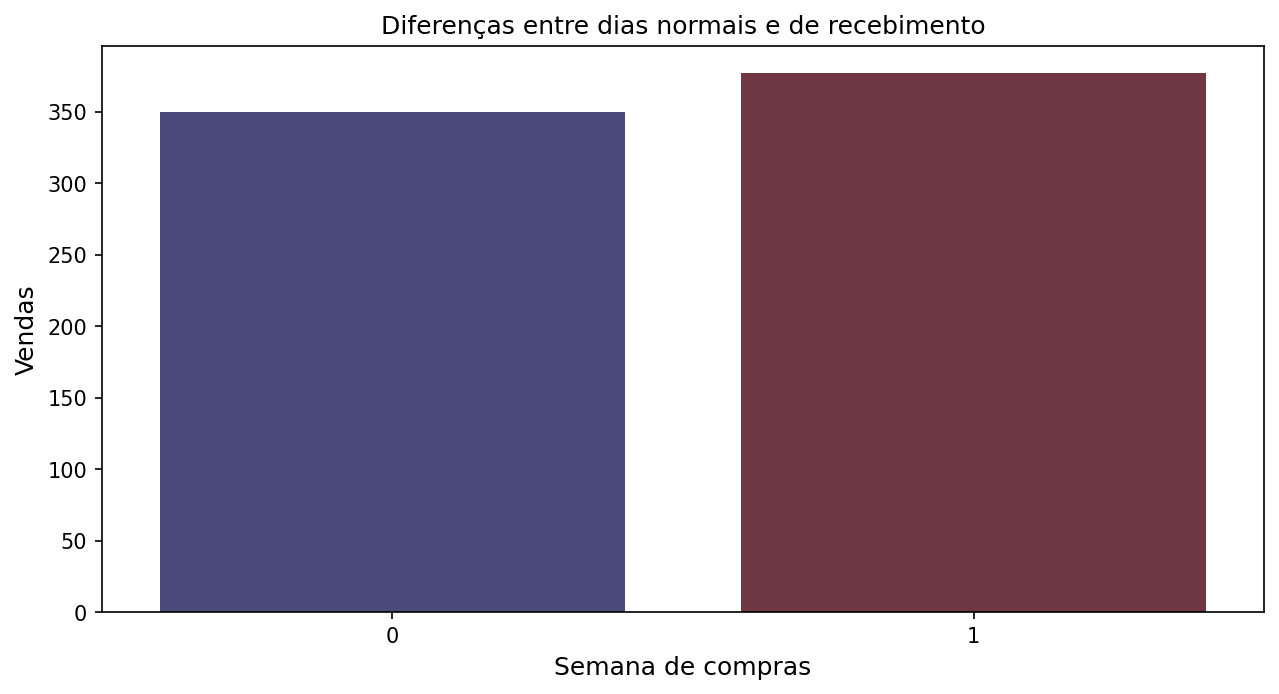

In [58]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = semana_agrupada,
            x = semana_agrupada.index,
            y = 'sales',
            palette = 'icefire')
plt.xlabel('Semana de compras', fontsize = 12)
plt.ylabel('Vendas', fontsize = 12)
plt.title('Diferenças entre dias normais e de recebimento');

É possível perceber uma leve diferença entre a semana normal e os dias seguintes ao recebimento do salário.

In [59]:
# Adicionando a lista de features categóricas:
cat_cols.append('semana_compras')

### Escalando as features numéricas:

In [60]:
def scale(df, series):
    scaler = MinMaxScaler()
    df[series] = scaler.fit_transform(df[series])
    return df 

In [61]:
train_df = scale(train_df, n_cols)

As features numéricas foram escaladas usando um método que deixa os valores entre 0 e 1. Esse método foi usado pois graças a distribuição dos dados, todo 0 se tornava um número negativo, o que não é o ideal pra modelagem, visto que 0 é um dos valores mais comuns na feature **"onpromotion"**.

### Codificando as features categóricas:

In [62]:
train_df[cat_cols].head()

,store_nbr,family,city,state,type_store,cluster,type_holiday,locale,locale_name,transferred,semana_compras
0,1,AUTOMOTIVE,Quito,Pichincha,D,13,Holiday,National,Ecuador,False,1
1,1,BABY CARE,Quito,Pichincha,D,13,Holiday,National,Ecuador,False,1
2,1,BEAUTY,Quito,Pichincha,D,13,Holiday,National,Ecuador,False,1
3,1,BEVERAGES,Quito,Pichincha,D,13,Holiday,National,Ecuador,False,1
4,1,BOOKS,Quito,Pichincha,D,13,Holiday,National,Ecuador,False,1


#### Features com muitos valores:

##### Cluster, State, Type_store, Locale, Type_holiday:

In [63]:
# Ordena as os valores por média de vendas:
def label_transformer(df, col):
    encode_df = df[[col,'sales']].groupby(col).mean().sort_values('sales', ascending = True)
    labels = encode_df.index.to_list()
    mapper = {d:n for d,n in zip(labels,range(0,len(labels)))}
    df[col] = df[col].map(mapper)
    return df    

In [64]:
for col in ["store_nbr", 'cluster', 'state', 'type_store' ,'locale', 'type_holiday']:
    train_df = label_transformer(train_df, col)

##### City, Family:

In [65]:
def encode_top_10(df, col):
    labels = df[[col,'sales']].groupby(col).mean().sort_values('sales', ascending = True).head(10).index.to_list()
    for label in labels:
        train_df[label] = np.where(train_df[col] == label, 1, 0)
    return df

In [66]:
# Codificando as 10 categorias com melhor média de vendas:
encode_top_10(train_df, 'city')
encode_top_10(train_df, 'family')

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,...,BOOKS,BABY CARE,HOME APPLIANCES,HARDWARE,MAGAZINES,SCHOOL AND OFFICE SUPPLIES,BEAUTY,PET SUPPLIES,LAWN AND GARDEN,AUTOMOTIVE
0,0,2013-01-01,22,AUTOMOTIVE,0.000,0.000000,0.495391,Quito,15,3,...,0,0,0,0,0,0,0,0,0,1
1,1,2013-01-01,22,BABY CARE,0.000,0.000000,0.495391,Quito,15,3,...,0,1,0,0,0,0,0,0,0,0
2,2,2013-01-01,22,BEAUTY,0.000,0.000000,0.495391,Quito,15,3,...,0,0,0,0,0,0,1,0,0,0
3,3,2013-01-01,22,BEVERAGES,0.000,0.000000,0.495391,Quito,15,3,...,0,0,0,0,0,0,0,0,0,0
4,4,2013-01-01,22,BOOKS,0.000,0.000000,0.495391,Quito,15,3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,41,POULTRY,438.133,0.000000,0.253228,Quito,15,2,...,0,0,0,0,0,0,0,0,0,0
3054344,3000884,2017-08-15,41,PREPARED FOODS,154.553,0.001350,0.253228,Quito,15,2,...,0,0,0,0,0,0,0,0,0,0
3054345,3000885,2017-08-15,41,PRODUCE,2419.729,0.199730,0.253228,Quito,15,2,...,0,0,0,0,0,0,0,0,0,0
3054346,3000886,2017-08-15,41,SCHOOL AND OFFICE SUPPLIES,121.000,0.010796,0.253228,Quito,15,2,...,0,0,0,0,0,1,0,0,0,0


##### Transferred:

In [67]:
train_df["transferred"] = np.where(train_df["transferred"] == True, 1, 0)

Graças ao fato da base de dados ter muitas linhas, é necessário escolher as categorias que serão codificadas, para não incorrer na maldição da dimensionalidade, ou tornar as features ordinais.

## Parte 4 - Feature Selection:

### Retirando as features que não vão agregar ao modelo:

In [68]:
y = train_df['sales']
train_df.drop(['id','date','family','city','sales','locale_name'], axis = 1, inplace = True)

As features retiradas não agregam ao modelo pois já foram codificadas, ou representam variavéis que não agregam informação digeríveis pelos modelos estátisticos.

### Seleção por ganho de informação:

In [69]:
inf_array = mutual_info_regression(train_df, y)

In [70]:
gain_df = pd.DataFrame(inf_array, index = train_df.columns, columns = ['Gain'])
gain_df.sort_values('Gain', ascending = False, inplace = True)
gain_df

,Gain
onpromotion,0.216136
store_nbr,0.139333
cluster,0.078680
state,0.056558
type_store,0.045987
dcoilwtico,0.043153
BOOKS,0.032511
BABY CARE,0.030545
AUTOMOTIVE,0.030230
HARDWARE,0.029286


Através do dataframe **"gain_df"** é possível entender o ganho informacional de cada feature no modelo, como a base de dados é relativamente grande, e o escopo da infraestrutura do projeto é pequeno, serão selecionadas as 15 features com maior relevância para o modelo.

In [71]:
# Separando as 15 features mais importantes:
top_15_features = gain_df.index[:15].to_list()

In [72]:
# Retirando as features que não vão entrar no modelo:
train_df = train_df[top_15_features]

In [73]:
# Salvando o progresso:
y.to_csv("y_regression.csv", index=False)
train_df.to_csv("train_regression.csv", index=False)

## Parte 5 - Escolhendo o modelo:

### Carregando os dados:

In [74]:
y = pd.read_csv("y_regression.csv")
train_df = pd.read_csv("train_regression.csv")
train_df.head()

,onpromotion,store_nbr,cluster,state,type_store,dcoilwtico,BOOKS,BABY CARE,AUTOMOTIVE,HARDWARE,HOME APPLIANCES,BEAUTY,SCHOOL AND OFFICE SUPPLIES,PET SUPPLIES,MAGAZINES
0,0.0,22,9,15,3,0.495391,0,0,1,0,0,0,0,0,0
1,0.0,22,9,15,3,0.495391,0,1,0,0,0,0,0,0,0
2,0.0,22,9,15,3,0.495391,0,0,0,0,0,1,0,0,0
3,0.0,22,9,15,3,0.495391,0,0,0,0,0,0,0,0,0
4,0.0,22,9,15,3,0.495391,1,0,0,0,0,0,0,0,0


### Modelos e metodologia de avaliação:

A metodologia de modelagem será a experimentação de diferentes modelos com o objetivo de reduzir ao máximo o erro das previsões do modelo. O modelo de base será uma Regressão Linear, que é um modelo simples e prático, porém que não gera resultados tão expressivos quanto outros modelos mais rebuscados, como os que serão testados após, como os modelos baseados em árvores de decisão. Portanto os experimentos ocorrerão na seguinte ordem:
1. Regressão Linear.
2. Rede Neural Artificial.
3. Floresta Aleatória.
4. Extreme Gradient Boosting Trees.


A base de dados vai ser dividida em conjunto de treinamento e de validação, pois será possível identificar o overfitting nos modelos. Sendo o conjunto de validação utilizado para computar a qualidade do modelo, enquanto o de treinamento será utilizado apenas para treinar o modelo. A métrica de resultados usada será o erro quadrático médio, conhecido como MSE, que computa o erro das previsões, portanto quanto menor o MSE melhor o modelo.

In [75]:
train_df, val_df, y, y_val = train_test_split(train_df,
                                              y,
                                              test_size=0.2, 
                                              shuffle=False, 
                                              random_state=42)

### Regressão Linear:

In [76]:
# Construindo o modelo de Regressão Linear:
linear_model = SGDRegressor(random_state=42)
linear_model.fit(train_df, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(random_state=42)

In [77]:
# Fazendo a previsão:
linear_predictions = linear_model.predict(val_df)

In [78]:
# MSE da Regressão Linear:
mse_linear = mean_squared_error(y_val, linear_predictions)
print(f"O MSE do modelo é : {mse_linear}")

O MSE do modelo é : 1290202.0554566272


O modelo de Regressão Linear teve um erro quadrático médio de 1.290.202, esse vai ser o modelo de base dos experimentos, e o objetivo dos próximos modelos é gerar previsões com um MSE menor do que 1.290.202.

### Rede Neural Artificial:

In [79]:
# Construindo a Rede Neural:
rede_neural = tf.keras.Sequential([
    tf.keras.layers.Dense(15, input_shape=[15]),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(60),
    tf.keras.layers.Dense(120),
    tf.keras.layers.Dense(1)
])

In [80]:
# Compilando a Rede Neural:
rede_neural.compile(loss=tf.keras.losses.mse,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])

In [81]:
# Treinando o modelo:
tf.random.set_seed(42)
rede_neural_history = rede_neural.fit(train_df,
                                      y,
                                      epochs=5,
                                      batch_size=128)

Epoch 1/5
19090/19090 [==============================] - 52s 3ms/step - loss: 927127.9375 - mse: 927127.9375
Epoch 2/5
19090/19090 [==============================] - 49s 3ms/step - loss: 899835.3125 - mse: 899835.3125
Epoch 3/5
19090/19090 [==============================] - 50s 3ms/step - loss: 897981.6875 - mse: 897981.6875
Epoch 4/5
19090/19090 [==============================] - 50s 3ms/step - loss: 897180.3125 - mse: 897180.3125
Epoch 5/5
19090/19090 [==============================] - 49s 3ms/step - loss: 896749.4375 - mse: 896749.4375


In [82]:
mse = rede_neural_history.history["mse"]
epochs = range(1,6)

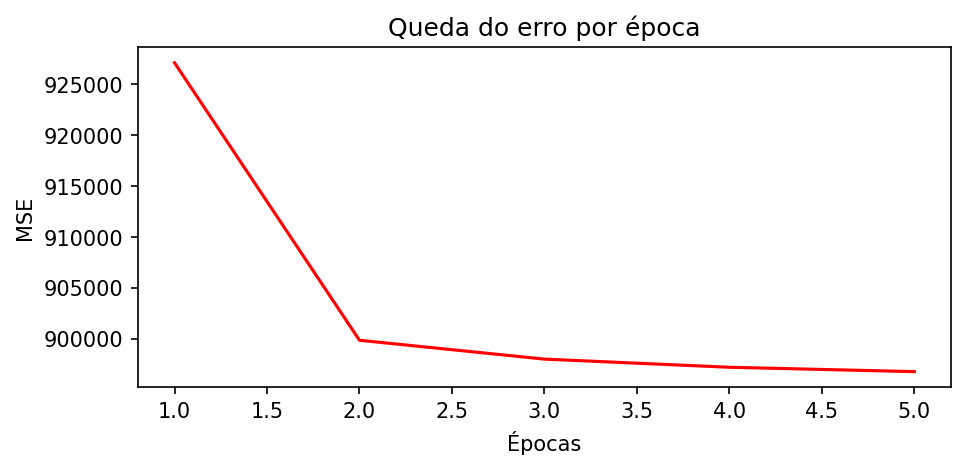

In [83]:
plt.figure(figsize=(7,3), dpi=150)
sns.lineplot(y=mse,
             x=epochs,
             color="red")
plt.title("Queda do erro por época")
plt.xlabel("Épocas")
plt.ylabel("MSE");

In [84]:
# Sumário do modelo:
rede_neural.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                240       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 60)                1860      
                                                                 
 dense_3 (Dense)             (None, 120)               7320      
                                                                 
 dense_4 (Dense)             (None, 1)                 121       
                                                                 
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Avaliando o modelo:
rede_neural.evaluate(val_df, y_val)

19090/19090 [==============================] - 37s 2ms/step - loss: 1186061.3750 - mse: 1186061.3750


[1186061.375, 1186061.375]

O modelo de Rede Neural Artifícial alcançou um erro quadrático médio de 1.186.061, que é um valor um tanto decepcionante, pois representa o erro do modelo por previsão, e um número dessa magnitude dada a escala dos dados, significa que o modelo tem um erro muito expressivo. Esse valor já superou o modelo de Regressão Linear, portanto a Rede Neural já é um dos modelos plausíveis para a previsão final.

### Floresta Aleatória:

In [86]:
# Construindo o modelo de Floresta Aleatória:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(train_df, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=42)

In [87]:
# Gerando previsões da Floresta Aleatória:
forest_predictions = random_forest.predict(val_df)

In [88]:
# MSE da Floresta Aleatória:
mse_forest = mean_squared_error(y_val, forest_predictions)
print(f"O MSE do modelo é : {mse_forest}")

O MSE do modelo é : 1785558.5915400935


In [89]:
# Entendendo a tomada de decisão da árvore:
features = random_forest.feature_names_in_
importance = random_forest.feature_importances_
feature_importance = pd.DataFrame({"features": features, "importance": importance})

In [90]:
feature_importance.sort_values("importance", ascending=False)

,features,importance
0,onpromotion,0.497565
5,dcoilwtico,0.244345
1,store_nbr,0.178504
2,cluster,0.021716
4,type_store,0.011648
3,state,0.008988
12,SCHOOL AND OFFICE SUPPLIES,0.007107
11,BEAUTY,0.005726
8,AUTOMOTIVE,0.005204
13,PET SUPPLIES,0.004213


O modelo de Arvóres Aleatórias gerou um resultado negativo, previsões com um erro quadrático médio de 1.785.558. Sendo inferior a Regressão Linear e consequentemente da Rede Neural, porém esse modelo é muito sensível a mudanças nos seus hiperparâmetros, que serão otimizados, com o objetivo de gerar resultados que superem a Regressão Linear:

In [91]:
# Função de optimização:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 1000)
    min_samples_split = trial.suggest_float("min_samples_split", 0, 1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 1, 1000)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 1])

    regressor = RandomForestRegressor(n_jobs=-1,
                                      random_state=42,
                                      max_features=max_features,
                                      n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      max_leaf_nodes=max_leaf_nodes)
    
    regressor.fit(train_df[:100_000], y[:100_000])
    predictions = regressor.predict(val_df)
    mse = mean_squared_error(y_val, predictions)
    return mse

In [ ]:
optimizer = optuna.create_study(direction='minimize')
optimizer.optimize(objective, n_trials=50)

In [93]:
# Melhores parâmetros:
optimizer.best_params

{'n_estimators': 709,
 'max_depth': 654,
 'min_samples_split': 0.005134173049409658,
 'min_samples_leaf': 19,
 'max_leaf_nodes': 335,
 'max_features': 1}

In [94]:
# Construindo o modelo optimizado:
optimized_forest = RandomForestRegressor(**optimizer.best_params)
optimized_forest.fit(train_df, np.ravel(y))

RandomForestRegressor(max_depth=654, max_features=1, max_leaf_nodes=335,
                      min_samples_leaf=19,
                      min_samples_split=0.005134173049409658, n_estimators=709)

In [95]:
# Resultado do modelo:
predictions = optimized_forest.predict(val_df)
mse_optimized_forest = mean_squared_error(y_val, predictions)
print(f"O MSE do modelo é {mse_optimized_forest}")

O MSE do modelo é 1282261.0202008134


O modelo de Floresta Aleatória após ser otimizado levou a um ganho de performance expressivo, Alcançando um erro quadrático médio de  1.282.261, uma redução expressiva do erro. Porém, apesar da melhora ainda é maior que o erro da Rede Neural, e ultrapassou por muito pouco a Regressão Linear.

### Extreme Gradient Boosting Trees:

In [96]:
# Construindo o modelo:
xgb_regressor = XGBRegressor(random_state=12,
                             n_jobs=-1)
xgb_regressor.fit(train_df, y)

[22:21:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1, random_state=12)

In [97]:
# Resultados do modelo:
xgb_preds = xgb_regressor.predict(val_df)
xgb_mse = mean_squared_error(y_val, xgb_preds)
print(f"O MSE do modelo é: {xgb_mse}")

O MSE do modelo é: 1156294.2738832186


O modelo de Extreme Gradient Boosting Trees é semelhante ao modelo de Floresta Aleatória em sua base, porém emprega diversas técnicas que potencializam os resultados do modelo, normalmente alcançando um resultado superior ao seu irmão. Dessa vez a norma se seguiu, o modelo alcançou um erro quadrático médio de 1.156.294 sem nenhuma otimização, superando todos os outros modelos até então.

In [100]:
# Função de otimização:
def objective_xgb(trial):
  n_estimators = trial.suggest_int("n_estimators", 0, 1000)
  max_depth = trial.suggest_int("max_depth", 0, 1000)
  max_leaves = trial.suggest_int("max_leaves", 0, 1000)
  growth_police = trial.suggest_categorical("growth_police", [0, 1])
  learning_rate = trial.suggest_float("learning_rate", 0, 1)
  gamma = trial.suggest_float("gamma",0, 2)
  reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
  reg_lambda = trial.suggest_float("reg_lambda", 0, 1)

  regressor = XGBRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves,
                           growth_police=growth_police,
                           learning_date=learning_rate,
                           gamma=gamma,
                           reg_alpha=reg_alpha,
                           tree_method="gpu_hist")

  regressor.fit(train_df[:100_000], y[:100_000])
  preds = regressor.predict(val_df)
  mse = mean_squared_error(y_val, preds)
  return mse

In [ ]:
xgb_optimizer = optuna.create_study(direction="minimize")
xgb_optimizer.optimize(objective_xgb, n_trials=50)

In [102]:
# Melhores parâmetros:
xgb_optimizer.best_params

{'n_estimators': 324,
 'max_depth': 749,
 'max_leaves': 21,
 'growth_police': 1,
 'learning_rate': 0.6109469538412059,
 'gamma': 1.9732572290639667,
 'reg_alpha': 0.9912565571973735,
 'reg_lambda': 0.0616203870690053}

In [105]:
# XGB optimizado:
xgb_optimizado = XGBRegressor(random_state=52, 
                              tree_method="gpu_hist", 
                              **xgb_optimizer.best_params)
xgb_optimizado.fit(train_df, y)

[22:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(gamma=1.9732572290639667, growth_police=1,
             learning_rate=0.6109469538412059, max_depth=749, max_leaves=21,
             n_estimators=324, random_state=52, reg_alpha=0.9912565571973735,
             reg_lambda=0.0616203870690053, tree_method='gpu_hist')

In [106]:
# Resultados do modelo:
xgb_optimizado_preds = xgb_optimizado.predict(val_df)
xgb_optimizado_mse = mean_squared_error(y_val, xgb_optimizado_preds)
print(f"O resultado do modelo foi um MSE de: {xgb_optimizado_mse}")

O resultado do modelo foi um MSE de: 1465063.9836664726


O modelo otimizado apresentou resultados piores que todos os modelos, provavelmente pois para a otimização foi utilizada uma amostra de 1/3 da base de dados, pois a infraestrutura do projeto não comportaria uma otimização completa, fora o fato das configurações padrões do modelo já serem bem otimizadas, sendo o MSE de 1.465.063.

### Resultados finais:
1. Extreme Gradient Boosting Trees: 1.156.294
2. Rede Neural Artificial: 1.186.061
3. Floresta Aleatória: 1.282.261
4. Regressão Linear: 1.290.202

Por fim, é possível concluir que o modelo mais adequado para o problema é o de Extreme Gradient Boosting Trees, pois apresenta o menor erro quadrático médio de todos, e esse é o parâmetro de avaliação estipulado anteriormente. Em seguida o modelo será utilizado nas previsões reais do projeto.

In [107]:
# Salvando o modelo final:
xgb_regressor.save_model("model.json")

## Parte 6 - Previsão:

### Preparação:

In [111]:
# Carregando o modelo:
modelo = xgb.Booster()
modelo.load_model("model.json")

[22:55:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Montando a base de dados de teste:

In [113]:
def agregar_dados(df):
    # Agregando informações:
    df = df.merge(stores_df, how = 'left', on = 'store_nbr')
    df = df.merge(oil_df, how = 'left', on = 'date')
    df = df.rename(columns={'type':'type_store'})
    return df

#### Relembrando as funções de transformação:

In [114]:
# Função de escala:
def scale(df, series):
    scaler = MinMaxScaler()
    df[series] = scaler.fit_transform(df[series])
    return df 

In [115]:
# Funções de codificação:
# Ordena as os valores por média de vendas:
def label_transformer(df, col, mapper):
    df[col] = df[col].map(mapper)
    return df

# Codifica as 10 categorias mais importantes:
def encode_family(df, labels):
    for label in labels:
        df[label] = np.where(df["family"] == label, 1, 0)
    return df

In [116]:
# Mapeadores:
cluster_mapper = {7: 0, 3: 1, 15: 2, 16: 3, 10: 4, 2: 5, 9: 6, 4: 7, 12: 8, 13: 9, 1: 10, 6: 11, 17: 12, 11: 13, 8: 14, 14: 15, 5: 16}

state_mapper =  {'Pastaza': 0, 'Manabi': 1, 'Cotopaxi': 2, 'Chimborazo': 3, 'Santa Elena': 4, 'Imbabura': 5, 
                 'Santo Domingo de los Tsachilas': 6, 'Bolivar': 7, 'Guayas': 8, 'Los Rios': 9, 'Esmeraldas': 10, 
                 'Azuay': 11, 'El Oro': 12, 'Loja': 13, 'Tungurahua': 14, 'Pichincha': 15}

type_store_mapper =  {'C': 0, 'E': 1, 'B': 2, 'D': 3, 'A': 4}

In [117]:
# Junção de toda a codificação:
def encoding(df):
    encode_family(df, ["BOOKS", "BABY CARE", "AUTOMOTIVE", 
                       "HARDWARE","HOME APPLIANCES", "BEAUTY", 
                       "SCHOOL AND OFFICE SUPPLIES",
                       "MAGAZINES", "PET SUPPLIES"])
    for col, mapper in zip(['cluster','state','type_store'], [cluster_mapper, state_mapper, type_store_mapper]):
        df = label_transformer(df, col, mapper)
    return df

#### Aplicando as transformações:

In [118]:
# Função agregada:
def transformar_dados(df):
    df = agregar_dados(df)
    df = encoding(df)
    df = df.drop(["family", "city", "date", "id"], axis=1)
    return df

In [119]:
# Aplicação:
test_df = transformar_dados(test_df)

In [120]:
test_df.head()

,store_nbr,onpromotion,state,type_store,cluster,dcoilwtico,BOOKS,BABY CARE,AUTOMOTIVE,HARDWARE,HOME APPLIANCES,BEAUTY,SCHOOL AND OFFICE SUPPLIES,MAGAZINES,PET SUPPLIES
0,1,0,15,3,9,46.8,0,0,1,0,0,0,0,0,0
1,1,0,15,3,9,46.8,0,1,0,0,0,0,0,0,0
2,1,2,15,3,9,46.8,0,0,0,0,0,1,0,0,0
3,1,20,15,3,9,46.8,0,0,0,0,0,0,0,0,0
4,1,0,15,3,9,46.8,1,0,0,0,0,0,0,0,0


### Previsão do conjunto de teste:

In [121]:
# Prevendo as vendas:
sales_array = rede_neural.predict(test_df)

In [122]:
# As previsões:
sales_array

array([[ 13859.134],
       [ 13862.362],
       [ 13871.942],
       ...,
       [176828.94 ],
       [176487.77 ],
       [176817.73 ]], dtype=float32)

#### Avaliando os resultados finais:

Os resultados das previsões será colocado em um dataset com os ids responsáveis pela identificação da entrada na base de dados, portanto será substituída a coluna **"sales"** no **sample_df**. 

In [123]:
# Substituíndo os valores 
sample_df.sales = sales_array

In [129]:
sample_df.to_csv("resultados.csv", index=False)

O resultado final foi um conjunto de previsões com o RMSLE (Root Mean Squared Logarithmic Error), outro método de avaliação de previsões, similar ao MSE, de 4.37970. Prevendo com precisão os dias com vendas, porém apresentando dificuldade em prever a ausência de vendas.

### Conclusão:

Do começo ao fim, o projeto passou por diversas etapas diferentes, de modo a gerar resultados melhores. A base de dados foi entendida e suas variáveis foram analisadas, os dados foram tratados, escalonados e codificados, foram criadas novas features para a modelagem e uma quantidade grande de features precisaram ser retiradas, pois como a infraestrutura do projeto é pequena, não haveria capacidade computacional suficiente para uma base de dados desse tamanho e com grande dimensionalidade. Os dados após serem preparados foram alimentados para diferentes tipos de modelo, visando identificar o melhor modelo para gerar as previsões de vendas, os modelos mais dependentes de otimização foram otimizados, e por fim o modelo de Extreme Gradient Boosting Trees foi escolhido para o problema em questão.
O modelo não teve a performance esperada, provavelmente graças aos cortes aplicados de modo a torna-lo possível, e também pela natureza do problema, talves houvesse sido uma melhor escolha aplicar diretamente métodos de previsão de séries temporais, como os modelos ARIMA e SARIMA. Porém, o projeto alcançou seu objetivo principal, não explicitado anteriormente, que era a oportunidade de desenvolver um projeto com dados reais e que engloba-se todos os aspectos do Aprendizado de Máquina. Agradeço a todos que investiram seus tempos em ler todo esse projeto !